In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

In [139]:
from utils import *

In [2]:
import random

In [3]:
import seaborn as sns
from matplotlib.transforms import Bbox

In [4]:
import statsmodels.api as sm

In [5]:
import joblib
from joblib import Parallel, delayed

In [6]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/djk2120/workers/', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300641', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [7]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension (h/t rabernat)
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [8]:
la1=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
la2=xr.open_dataset('mpi_mask_grnlnd_antarc.nc').landarea
las={'CESM1':la1,'CESM2':la1,'MPIGE':la2,'MPI12':la2}
mdls=['CESM1','CESM2','MPIGE','MPI12']

In [9]:
def get_ix(ds,yr0,yr1):
    avoids=[1962,1963,1982,1991,1992,1993]
    ix=(ds['year']>=yr0)&(ds['year']<=yr1)
    for yr in avoids:
        ix=(ix)&(ds['year']!=yr)
    return ix

In [10]:
def getmems(ds,yy,ee,latrop,la,v='NEE'):

    ix=get_ix(ds,yy[0],yy[1])
    xa=1e-9*(latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year'))
    ya=1e-9*24*60*60*365*(la.sum()*detrend_dim(ds[v].isel(year=ix),'year'))

    return xa.isel(ens=ee),ya.isel(ens=ee)

In [13]:
def getyy(ds,c,ny):
    if c=='a':
        yy=[1960,1989]
    elif c=='b':
        yy=[1989,2018]
    elif c=='c':
        yy=[2073,2099]
    else:
        go=True
        i=0
        yy=np.array([c,c])
        a=[np.array([-1,0]),np.array([0,1])]
        while go:
            i+=1
            yy=yy+a[i%2]
            ix=get_ix(ds,yy[0],yy[1])
            if ix.sum()==ny:
                go=False
    return yy


In [14]:
def getp(xs,ys,nx):
    nyrs=len(xs[0].year)
    X=np.zeros([nyrs*nx*2,2])
    y=np.zeros(nyrs*nx*2)

    pvals=[]

    for j in range(100):

        for i in range(2):
            nens=len(xs[i].ens)
            ee=random.sample(range(nens),nx)

            ix=nyrs*nx*i+np.arange(nyrs*nx)
            X[ix,0]=xs[i].isel(ens=ee).values.ravel()
            if i==1:
                X[ix,1]=xs[i].isel(ens=ee).values.ravel()

            y[ix]=ys[i].isel(ens=ee).values.ravel()

        lm=sm.OLS(y,X).fit()
        pvals.append(lm.pvalues[1])
    return pvals

### verify SW_trop vs TWS_trop

In [178]:
mdl='CESM2'
la=las[mdl]
latrop=la*(abs(la.lat)<24)
f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
ds=xr.open_dataset(f)

In [181]:
yy=getyy('b','b','b')
ix=get_ix(ds,yy[0],yy[1])

In [191]:
sw=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
tws=1e-9*latrop.sum()*detrend_dim(ds.TWS_TROP.isel(year=ix),'year')

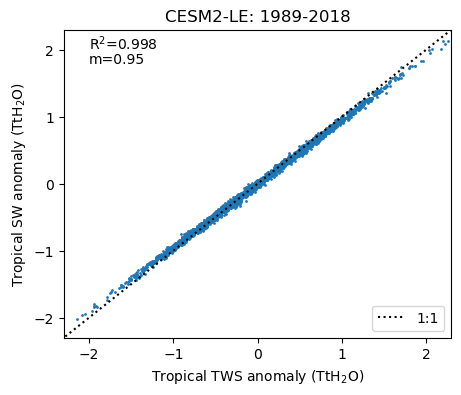

In [220]:
plt.figure(figsize=[5,4])
plt.plot([-5,-4],[-5,-4],'k:',label='1:1')
plt.legend(loc=4)

plt.plot(tws.values.ravel(),sw.values.ravel(),'.',ms=2)
plt.plot([-3,3],[-3,3],'k:')
plt.xlim([-2.3,2.3])
plt.ylim([-2.3,2.3])
plt.xlabel('Tropical TWS anomaly (TtH$_2$O)')
plt.ylabel('Tropical SW anomaly (TtH$_2$O)')
m,b,r,p,err=stats.linregress(tws.values.ravel(),sw.values.ravel())
plt.text(-2,2,'R$^2$='+str(np.round(r**2,3)))
plt.text(-2,1.8,'m='+str(np.round(m,2)));
plt.title('CESM2-LE: 1989-2018') 
plt.savefig('../figs/supp/TWS_vs_SW.png',dpi=300,bbox_inches='tight')


### bootstrapping

In [173]:
mdl='CESM2'
la=las[mdl]
latrop=la*(abs(la.lat)<24)
f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
ds=xr.open_dataset(f)
yy=getyy(ds,'b',0)

x,y=getmems(ds,yy,ds.ens,latrop,la)
nens=len(x.ens)
ny=len(x.year)

In [174]:
xe=x.stack({'ey':['ens','year']}).compute()
ye=y.stack({'ey':['ens','year']}).compute()
years=[np.random.randint(ny*nens,size=ny) for i in range(5000)]
m2=[stats.linregress(xe.isel(ey=year),ye.isel(ey=year))[0] for year in years]

In [175]:
with joblib.parallel_config(backend="dask"):
    results = Parallel()(delayed(getm)(x,y,ee,50) for ee in range(nens))
m1=np.array(results).ravel()

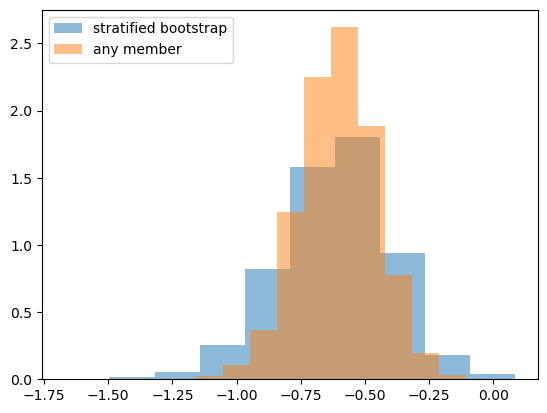

In [176]:
plt.hist(m1,density=True,alpha=0.5,label='stratified bootstrap')
plt.hist(m2,density=True,alpha=0.5,label='any member')
plt.legend();

In [134]:
import glob

In [135]:
v='NEE'
d='/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001/lnd/proc/tseries/month_1/'
files=sorted(glob.glob(d+'*h0.'+v+'.*'))
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',decode_times=False,parallel=True)
ds['time']=xr.cftime_range('1000',periods=len(ds.time),freq='MS',calendar='noleap')
v='TWS'
d='/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001/lnd/proc/tseries/month_1/'
files=sorted(glob.glob(d+'*h0.'+v+'.*'))
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    tmp=xr.open_mfdataset(files,combine='nested',concat_dim='time',decode_times=False,parallel=True)
tmp['time']=xr.cftime_range('1000',periods=len(ds.time),freq='MS',calendar='noleap')
ds['TWS']=tmp.TWS

In [146]:
x=gmean(amean(ds.TWS),latrop)
y=24*60*60*365*gmean(amean(ds.NEE),la)

In [153]:
years=[np.random.randint(2000,size=27) for i in range(5000)]
m2=[stats.linregress(x.isel(year=year),y.isel(year=year))[0] for year in years]

In [158]:
years=[np.random.randint(1973)+np.arange(27) for i in range(5000)]
m1=[stats.linregress(x.isel(year=year),y.isel(year=year))[0] for year in years]

1.1248540069993809

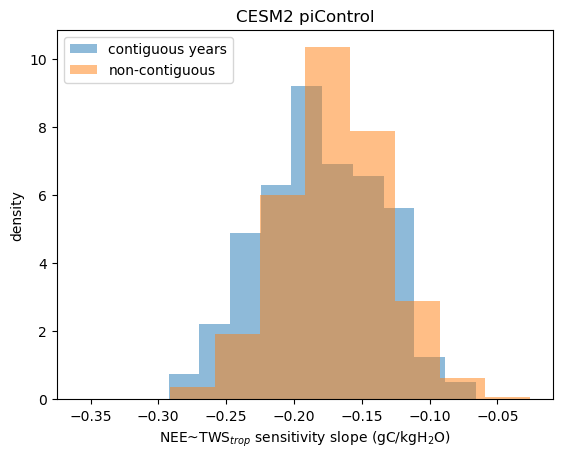

In [168]:
plt.hist(m1,density=True,alpha=0.5,label='contiguous years')
plt.hist(m2,density=True,alpha=0.5,label='non-contiguous')
plt.title('CESM2 piControl')
plt.legend(loc=2)
plt.xlabel('NEE~TWS$_{trop}$ sensitivity slope (gC/kgH$_2$O)')
plt.ylabel('density');
np.std(m1)/np.std(m2)

In [109]:
def getm(x,y,ee,nx):
    years=[np.random.randint(ny,size=ny) for i in range(nx)]
    m=[stats.linregress(x.isel(ens=ee,year=year),y.isel(ens=ee,year=year) )[0] for year in years]
    return m

In [95]:

xs,ys,=[],[]
nxs=range(1,16)
for mdl in ['CESM1','CESM2']:
    la=las[mdl]
    latrop=la*(abs(la.lat)<24)
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    yy=[1989,2018]
    x,y=getmems(ds,yy,ds.ens,latrop,la)
    xs.append(x)
    ys.append(y)
with joblib.parallel_config(backend="dask"):
    results = Parallel()(delayed(getp)(xs,ys,nx) for nx in nxs for i in range(50))

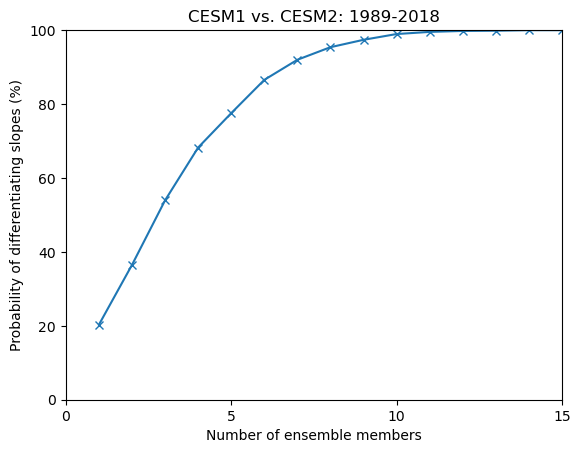

In [107]:

plt.plot(nxs,(np.array(results).reshape([len(nxs),5000])<0.05).sum(axis=1)/50,'-x')
plt.ylim([0,100])
plt.xlim([0,15])
plt.xticks(range(0,16,5));
plt.title('CESM1 vs. CESM2: 1989-2018')
plt.xlabel('Number of ensemble members')
plt.ylabel('Probability of differentiating slopes (%)');

In [18]:
y1=1989
y2=2018
v='NEE'
mdl='MPI12'
la=las[mdl]
latrop=la*(abs(la.lat)<24)
f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
ds=xr.open_dataset(f)


In [250]:
yy0=[np.array([2000,2000])]
a=[np.array([-1,0]),np.array([0,1])]
for i in range(20):
    for j in range(2):
        yy0.append(yy0[-1]+a[j])
        
nys=[10,15,20,25,30]
x=[]
yys=[]
for yy in yy0:
    ix=get_ix(ds,yy[0],yy[1])
    ny=ix.sum().values
    if ny in nys:
        if ny not in x:
            yys.append(yy)
            x.append(ny)
 

In [251]:
xs=[getmems(ds,yy,ds.ens)[0] for yy in yys]
ys=[getmems(ds,yy,ds.ens)[1] for yy in yys]

In [256]:
with joblib.parallel_config(backend="dask"):
    results = Parallel(verbose=100)(delayed(mvals)(x,y,1) for x,y in zip(xs,ys))

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


In [258]:
[np.round(np.std(r) for r in results]

[0.8812879600566171,
 0.6349656275761242,
 0.5310745879146944,
 0.431288182754011,
 0.38569033232453975]

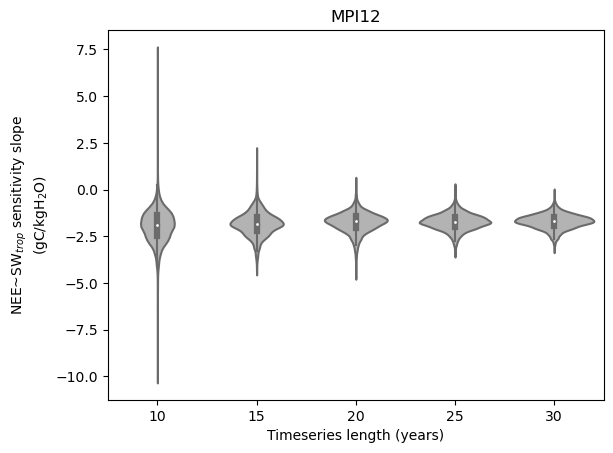

In [257]:
df=pd.DataFrame(np.array(results).T)
sns.violinplot(df,color=[0.7,0.7,0.7])
plt.xticks(range(len(nys)),nys);
plt.xlabel('Timeseries length (years)')
plt.ylabel('NEE~SW$_{trop}$ sensitivity slope\n(gC/kgH$_2$O)')
plt.title(mdl);

In [ ]:
### what's the probability of distinguishing two models, given 10,15,20,... years 

In [279]:
help(getmems)

Help on function getmems in module __main__:

getmems(ds, yy, ee, v='NEE')



In [ ]:
v='NEE'
mdl='MPI12'
la=las[mdl]
latrop=la*(abs(la.lat)<24)
f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
ds=xr.open_dataset(f)
yy=
getmems(ds,yy,ee,latrop,la,v='NEE')

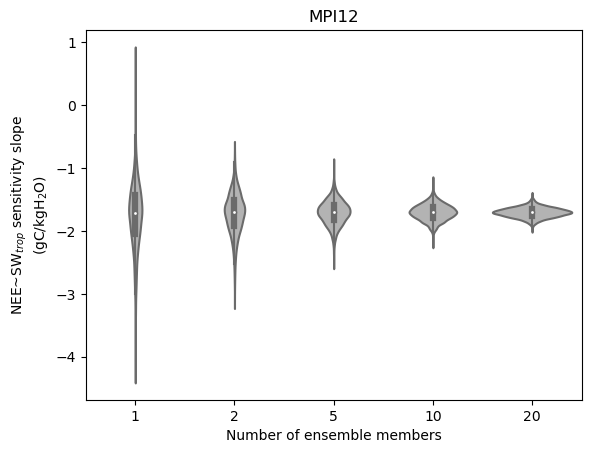

In [278]:
sns.violinplot(pd.DataFrame(np.array(results2).T),color=[0.7,0.7,0.7])
plt.xlabel('Number of ensemble members')
plt.ylabel('NEE~SW$_{trop}$ sensitivity slope\n(gC/kgH$_2$O)')
plt.xticks(range(len(nys)),nxs);
plt.title(mdl);

In [273]:
[np.std(r) for r in results]

[0.8812879600566171,
 0.6349656275761242,
 0.5310745879146944,
 0.431288182754011,
 0.38569033232453975]

In [276]:
nxs=[1,2,5,10,20]

In [271]:
x=xs[2]
y=ys[2]
nxs=[1,2,5,10,20]
with joblib.parallel_config(backend="dask"):
    results2 = Parallel(verbose=100)(delayed(mvals)(x,y,nx) for nx in nxs)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.5s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.4s finished


In [254]:
def mvals(x,y,nx):
    nens=len(x.ens)
    ny=len(x.year)
    out=[]
    for i in range(5000):
        ee=random.sample(range(nens),nx)
        xs,ys=[],[]
        for e in ee:
            yrs=np.random.randint(ny,size=ny)
            xs.append(x.isel(ens=e,year=yrs))
            ys.append(y.isel(ens=e,year=yrs))
        m=stats.linregress(np.array(xs).ravel(),
                           np.array(ys).ravel())[0]
        out.append(m)
    return out


In [91]:
def mvals(ds,yy):
    x,y=getmems(ds,yy,ds.ens)
    ny=len(x.year)
    out=[]
    for i in range(5000):
        ee=np.random.randint(30)
        yrs=random.sample(range(ny),ny)
        m=stats.linregress(x.isel(ens=ee,year=yrs),y.isel(ens=ee,year=yrs))[0]
        out.append(m)
    return out

In [12]:
y1s=[1960,1989,2073]
y2s={1960:1989,1989:2018,2073:2099}

In [40]:
pvals={mdl:{} for mdl in mdls}

In [52]:
for mdl in mdls:

    la=las[mdl]
    latrop=la*(abs(la.lat)<24)
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    nens=len(ds.ens)
    ee=ds.ens
    for i in range(3):
        for j in range(i+1,3):
            yra=y1s[i]
            yrb=y1s[j]

            xa,ya=getmems(ds,yra,ee)
            xb,yb=getmems(ds,yrb,ee)
            X=np.vstack([np.hstack([xa,xb]),np.hstack([0*xa,xb])]).T
            y=np.hstack([ya,yb])
            lm=sm.OLS(y,X).fit()
            pvals[mdl][str(yra)+'-'+str(yrb)]=np.round(lm.pvalues[1],3)

In [77]:
def getxy(mdl):
    v='NEE'
    la=las[mdl]
    latrop=la*(abs(la.lat)<24)
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)

    y1s=[1960,1989,2073]
    y2s={1960:1989,1989:2018,2073:2099}
    xs=[]
    ys=[]

    for y1 in y1s:
        ix=get_ix(ds,y1,y2s[y1])
        xa=1e-9*(latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year'))
        ya=1e-9*24*60*60*365*(la.sum()*detrend_dim(ds[v].isel(year=ix),'year'))
        xa['year']=range(len(xa.year))
        ya['year']=range(len(xa.year))
        xs.append(xa)
        ys.append(ya)

    x=xr.concat(xs,dim='period')
    y=xr.concat(ys,dim='period')
    x['period']=y1s
    y['period']=y1s

    return x,y

In [282]:
def getp(x,y,ees,periods):
    pvals=[]
    for ee in ees:
        xs,ys=[],[]

        for i,p in enumerate(periods):
            xs.append(x.isel(ens=ee[i],period=p).values.ravel())
            ys.append(y.isel(ens=ee[i],period=p).values.ravel())
        xx=np.vstack([np.hstack([xs[0],xs[1]]),
                      np.hstack([0*xs[0],xs[1]])]).T
        yy=np.hstack([ys[0],ys[1]])
        lm=sm.OLS(yy,xx).fit()
        pvals.append(lm.pvalues[1])
    return pvals
    

In [239]:
def pcomp(mdl,periods):
    x,y=getxy(mdl)
    nens=len(x.ens)
    pout=[]

    nx=1
    ees=[(i,j) for i in range(nens) for j in range(nens)]
    pvals=getp(x,y,ees,periods)
    pout.append((np.array(pvals)<0.05).sum()/len(pvals))

    nxs=range(2,21)
    eess=[[(random.sample(range(nens),nx),random.sample(range(nens),nx)) for i in range(10000)] for nx in nxs]
    with joblib.parallel_config(backend="dask"):
        results = Parallel()(delayed(getp)(x,y,ees,periods) for ees in eess)
    for nx,p in zip(nxs,results):
        pout.append((np.array(p)<0.05).sum()/len(p))
    return pout

In [258]:
eess=[[(random.sample(range(100),nx),random.sample(range(100),nx)) for i in range(10000)] for nx in range(2,62,2)]

In [297]:
x,y=getxy('MPI12')

In [316]:
ee=[1]


<xarray.DataArray (ey: 27)>
array([-0.68446818, -0.17752674,  1.03079585,  0.429082  , -0.67830836,
       -0.35839569,  0.26156523,  0.61137409,  0.41320133, -0.26707267,
       -0.18590271,  0.01378039,  0.14643718, -0.27602326, -0.4324376 ,
        0.2355233 ,  0.2752105 ,  0.32970599,  0.21062498,  0.11170324,
       -0.55748767, -0.63176918, -0.24619429, -0.32234907, -0.15449582,
        0.39925317,  0.50417401])
Coordinates:
    period   int64 1989
  * ey       (ey) object MultiIndex
  * ens      (ey) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  * year     (ey) int64 0 1 2 3 4 5 6 7 8 9 10 ... 17 18 19 20 21 22 23 24 25 26

In [319]:
p=1
m=[]
for nx in range(1,31,5):
    mvals=[]
    for i in range(5000):
        ee=random.sample(range(30),nx)
        xx=x.isel(period=1,ens=ee).stack({'ey':['ens','year']})
        yy=y.isel(period=1,ens=ee).stack({'ey':['ens','year']})
        r=np.random.randint(len(xx),size=27)
        mvals.append(stats.linregress(xx.isel(ey=r),yy.isel(ey=r))[0])
    m.append(mvals)



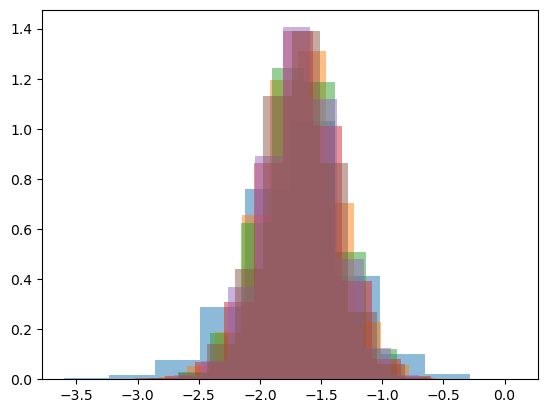

In [320]:
for mvals in m:
    plt.hist(mvals,alpha=0.5,density=True)

In [296]:
for mdl in mdls:
    print(mdl)
    print('--------')
    x,y=getxy(mdl)
    ees=[(x.ens,x.ens)]

    pps=[getp(x,y,ees,[0,1]),getp(x,y,ees,[1,2])]
    s=['NS','*']

    ms=[]
    for i in range(3):
        m,b,r,p,err=stats.linregress(x.isel(period=i).values.ravel(),
                                     y.isel(period=i).values.ravel())
        print(y1s[i],np.round(m,3))
        if i<2:
            print(s[int(pps[i][0]<0.05)])
    print('--------')


CESM1
--------
1960 -1.169
NS
1989 -1.103
NS
2073 -1.083
--------
CESM2
--------
1960 -0.546
*
1989 -0.604
*
2073 -0.394
--------
MPIGE
--------
1960 -2.146
*
1989 -1.989
*
2073 -1.68
--------
MPI12
--------
1960 -1.705
NS
1989 -1.67
*
2073 -1.166
--------


LinregressResult(slope=-0.6038051086853125, intercept=-8.675709648636452e-15, rvalue=-0.6239326539623126, pvalue=3.0239136651591464e-291, stderr=0.014559783431251024, intercept_stderr=0.009776341815693902)

In [281]:
-0.5464-0.0574

-0.6038

In [277]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.408
Model:                            OLS   Adj. R-squared (uncentered):              0.407
Method:                 Least Squares   F-statistic:                              1857.
Date:                Mon, 25 Sep 2023   Prob (F-statistic):                        0.00
Time:                        17:07:22   Log-Likelihood:                         -3419.7
No. Observations:                5400   AIC:                                      6843.
Df Residuals:                    5398   BIC:                                      6856.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5464      0.014    -39.720      0.000      -0.573      -0.519
x2            -0.0574      0.019     -3.026      0.002      -0.095      -0.020
==============================================================================
Omnibus:                      124.350   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.125
Skew:                           0.286   Prob(JB):                     6.24e-36
Kurtosis:                       3.627   Cond. No.                         2.68
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [269]:
x.isel(period=0)

<xarray.DataArray (ens: 100, year: 27)>
array([[-1.38224324e+00,  6.77297283e-01,  1.47478842e-01, ...,
        -9.83452048e-01, -1.75705124e-01,  1.72546363e-01],
       [ 3.08084967e-01, -2.91928247e-02, -1.32915467e+00, ...,
         4.01059939e-01,  4.94281203e-01,  3.50223438e-01],
       [-6.74072350e-01,  5.97196910e-01,  4.62638676e-01, ...,
         8.65637766e-01, -2.38899571e-01, -1.06801607e-01],
       ...,
       [ 3.32792939e-02, -7.73053441e-01, -1.11546374e-01, ...,
        -4.71605699e-02,  8.43609269e-01,  3.74881851e-01],
       [ 1.03228071e+00, -2.22241134e-03, -3.34080701e-01, ...,
        -2.93158238e-04,  1.60760458e+00,  4.96580950e-01],
       [-3.63898019e-01, -3.64541470e-01, -1.34380713e+00, ...,
        -4.73629530e-02, -3.61610489e-01, -1.21228400e-02]])
Coordinates:
  * year     (year) int64 0 1 2 3 4 5 6 7 8 9 ... 17 18 19 20 21 22 23 24 25 26
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
    period   int64 1960

In [260]:
with joblib.parallel_config(backend="dask"):
    results = Parallel()(delayed(getp)(x,y,ees,[0,1]) for ees in eess)

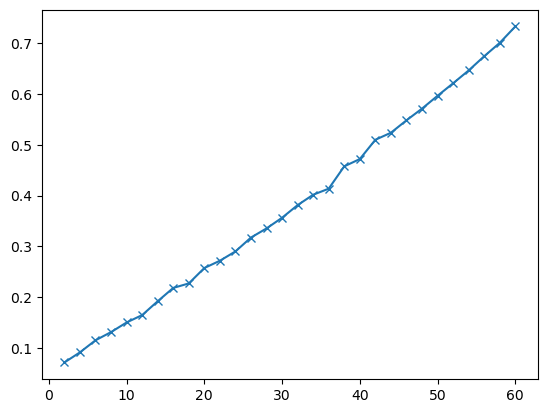

In [264]:
p=[(np.array(p)<0.05).sum()/len(p) for p in results]
plt.plot(range(2,62,2),p,'-x')

(0.0, 1.0)

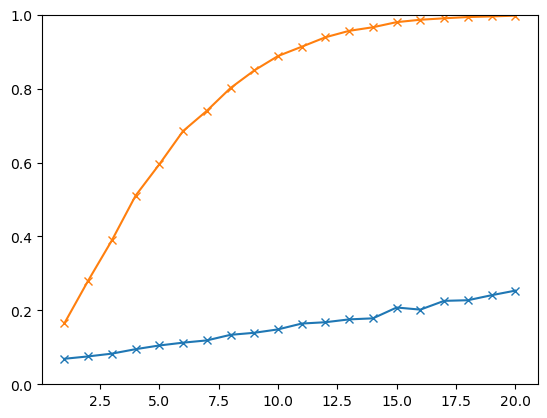

In [247]:
p0=pcomp('CESM2',[0,1])
p1=pcomp('CESM2',[1,2])
plt.plot(range(1,21),p0,'-x')
plt.plot(range(1,21),p1,'-x')
plt.ylim([0,1])

In [121]:
for nx in range(1,11):
    pvals=[]

    for rr in range(5000):
        xs,ys=[],[]

        for i in range(2):
            ee=random.sample(range(nens),nx)
            xs.append(x.isel(ens=ee,period=i).values.ravel())
            ys.append(y.isel(ens=ee,period=i).values.ravel())


        xx=np.vstack([np.hstack([xs[0],xs[1]]),
                      np.hstack([0*xs[0],xs[1]])]).T
        yy=np.hstack([ys[0],ys[1]])
        lm=sm.OLS(yy,xx).fit()
        pvals.append(lm.pvalues[1])
    print(nx,(np.array(pvals)<0.05).sum())

1 104
2 95
3 89
4 55
5 66
6 59
7 65
8 36
9 39
10 41


51

In [67]:
%%time
nens=30
nx=5
pvals=[]
ia,ib=0,1
for i in range(500):
    eea=random.sample(range(nens),nx)
    eeb=random.sample(range(nens),nx)

    xx=np.vstack([np.hstack([x.isel(ens=eea,xb]),
                 np.hstack([0*xa,xb])]).T
    yy=np.hstack([ya,yb])
    lm=sm.OLS(y,X).fit()
    pvals.append(lm.pvalues[1])

CPU times: user 22.7 s, sys: 70.3 ms, total: 22.8 s
Wall time: 23.5 s


In [67]:
%%time
nens=30
nx=5
pvals=[]
yra,yrb=1960,1989
for i in range(500):
    eea=random.sample(range(nens),nx)
    eeb=random.sample(range(nens),nx)
    xa,ya=getmems(ds,yra,eea)
    xb,yb=getmems(ds,yrb,eeb)
    X=np.vstack([np.hstack([xa,xb]),np.hstack([0*xa,xb])]).T
    y=np.hstack([ya,yb])
    lm=sm.OLS(y,X).fit()
    pvals.append(lm.pvalues[1])

CPU times: user 22.7 s, sys: 70.3 ms, total: 22.8 s
Wall time: 23.5 s


In [56]:
help(random.sample)

Help on method sample in module random:

sample(population, k, *, counts=None) method of random.Random instance
    Chooses k unique random elements from a population sequence.
    
    Returns a new list containing elements from the population while
    leaving the original population unchanged.  The resulting list is
    in selection order so that all sub-slices will also be valid random
    samples.  This allows raffle winners (the sample) to be partitioned
    into grand prize and second place winners (the subslices).
    
    Members of the population need not be hashable or unique.  If the
    population contains repeats, then each occurrence is a possible
    selection in the sample.
    
    Repeated elements can be specified one at a time or with the optional
    counts parameter.  For example:
    
        sample(['red', 'blue'], counts=[4, 2], k=5)
    
    is equivalent to:
    
        sample(['red', 'red', 'red', 'red', 'blue', 'blue'], k=5)
    
    To choose a sample fr

### Main Figure 1

In [20]:
def get5000(mdl,y1,y2):

    v='NEE'
    la=las[mdl]
    latrop=la*(abs(la.lat)<24)
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    ix=get_ix(ds,y1,y2)
    xa=1e-9*(latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year'))
    ya=1e-9*24*60*60*365*(la.sum()*detrend_dim(ds[v].isel(year=ix),'year'))
    nens=len(ds.ens)

    with joblib.parallel_config(backend="dask"):
        results = Parallel()(delayed(slopes)(x,y) for x,y in zip(xa,ya))
    
    return results


In [16]:
def slopes(x,y):
    ixr=xr.DataArray(np.random.randint(27,size=[5000,27]),dims=['draw','year'])
    m=[stats.linregress(xx,yy)[0] for xx,yy in zip(x.isel(year=ixr),y.isel(year=ixr))]
    return m

In [190]:
y1s=[1960,1989,2073]
y2={1960:1989,1989:2018,2073:2099}

In [193]:
mdl='MPI12'
a=1960
b=1989


v='NEE'
la=las[mdl]
latrop=la*(abs(la.lat)<24)
f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
ds=xr.open_dataset(f)


xas=[]
yas=[]
for y1 in [a,b]:
    ix=get_ix(ds,y1,y2[y1])
    xa=1e-9*(latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year'))
    ya=1e-9*24*60*60*365*(la.sum()*detrend_dim(ds[v].isel(year=ix),'year'))
    xas.append(xa)
    yas.append(ya)
    
    


In [238]:
nens=30
p=[]

for nx in range(1,21):
    if nx==1:
        eesets=[([a],[b]) for a in range(30) for b in range(30)]
    elif nx==29:
        eesets=[(np.arange(30)[np.arange(30)!=i],
                 np.arange(30)[np.arange(30)!=j]) 
                for i in range(30) for j in range(30)]
    else:
        eesets=[(random.sample(range(nens),nx),random.sample(range(nens),nx)) for i in range(5000)]
    pvals=[]

    for ees in eesets:
        x=np.hstack([xas[i].isel(ens=ees[i]).values.ravel() for i in range(2)])
        y=np.hstack([yas[i].isel(ens=ees[i]).values.ravel() for i in range(2)])

        t=np.linspace(0,2,len(x))>1
        lm=sm.OLS(y,np.vstack([x,t*x]).T).fit()
        pvals.append(lm.pvalues[1])
    p.append(100*(np.array(pvals)<0.05).sum()/len(eesets))

(0.0, 5.0)

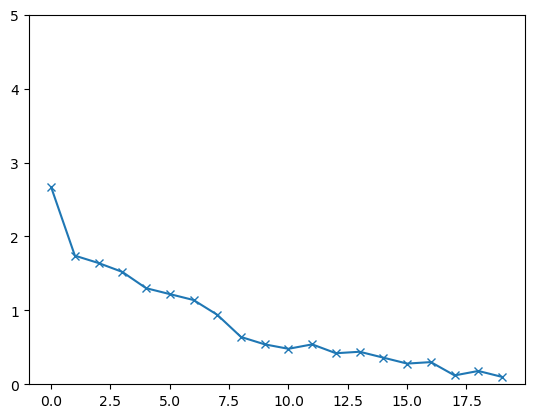

In [239]:
plt.plot(p,'-x')
plt.ylim([0,5])

In [217]:
eesets[:50]

[([0], [0]),
 ([0], [1]),
 ([0], [2]),
 ([0], [3]),
 ([0], [4]),
 ([0], [5]),
 ([0], [6]),
 ([0], [7]),
 ([0], [8]),
 ([0], [9]),
 ([0], [10]),
 ([0], [11]),
 ([0], [12]),
 ([0], [13]),
 ([0], [14]),
 ([0], [15]),
 ([0], [16]),
 ([0], [17]),
 ([0], [18]),
 ([0], [19]),
 ([0], [20]),
 ([0], [21]),
 ([0], [22]),
 ([0], [23]),
 ([0], [24]),
 ([0], [25]),
 ([0], [26]),
 ([0], [27]),
 ([0], [28]),
 ([0], [29]),
 ([1], [0]),
 ([1], [1]),
 ([1], [2]),
 ([1], [3]),
 ([1], [4]),
 ([1], [5]),
 ([1], [6]),
 ([1], [7]),
 ([1], [8]),
 ([1], [9]),
 ([1], [10]),
 ([1], [11]),
 ([1], [12]),
 ([1], [13]),
 ([1], [14]),
 ([1], [15]),
 ([1], [16]),
 ([1], [17]),
 ([1], [18]),
 ([1], [19])]

In [ ]:
mdl='MPI12'

In [131]:
mdl='MPI12'
v='NEE'
la=las[mdl]
latrop=la*(abs(la.lat)<24)
f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
ds=xr.open_dataset(f)

xas=[]
yas=[]
for y1,y2 in zip(y1s,y2s):
    ix=get_ix(ds,y1,y2)
    xa=1e-9*(latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year'))
    ya=1e-9*24*60*60*365*(la.sum()*detrend_dim(ds[v].isel(year=ix),'year'))
    xas.append(xa)
    yas.append(ya)



In [187]:
ees=np.arange(30)
x=np.hstack([xas[0].isel(ens=ees).values.ravel(),
             xas[1].isel(ens=ees).values.ravel()])
y=np.hstack([yas[0].isel(ens=ees).values.ravel(),
             yas[1].isel(ens=ees).values.ravel()])

t=np.linspace(0,2,len(x))>1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.589
Model:                            OLS   Adj. R-squared (uncentered):              0.588
Method:                 Least Squares   F-statistic:                              1159.
Date:                Wed, 20 Sep 2023   Prob (F-statistic):                   5.29e-313
Time:                        09:42:30   Log-Likelihood:                         -1937.2
No. Observations:                1620   AIC:                                      3878.
Df Residuals:                    1618   BIC:                                      3889.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.7045      0.050    -33.895      0.000      -1.803      -1.606
x2             0.0349      0.070      0.497      0.619      -0.103       0.172
==============================================================================
Omnibus:                        6.924   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.015
Skew:                          -0.157   Prob(JB):                       0.0300
Kurtosis:                       2.930   Cond. No.                         2.65
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [188]:
ees=np.arange(30)
x=np.hstack([xas[2].isel(ens=ees).values.ravel(),
             xas[1].isel(ens=ees).values.ravel()])
y=np.hstack([yas[2].isel(ens=ees).values.ravel(),
             yas[1].isel(ens=ees).values.ravel()])

t=np.linspace(0,2,len(x))>1
lm=sm.OLS(y,np.vstack([x,t*x]).T).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.551
Model:                            OLS   Adj. R-squared (uncentered):              0.551
Method:                 Least Squares   F-statistic:                              994.5
Date:                Wed, 20 Sep 2023   Prob (F-statistic):                   2.17e-282
Time:                        09:42:58   Log-Likelihood:                         -1938.6
No. Observations:                1620   AIC:                                      3881.
Df Residuals:                    1618   BIC:                                      3892.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1663      0.041    -28.679      0.000      -1.246      -1.087
x2            -0.5034      0.064     -7.916      0.000      -0.628      -0.379
==============================================================================
Omnibus:                       11.668   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.399
Skew:                          -0.180   Prob(JB):                      0.00335
Kurtosis:                       2.803   Cond. No.                         2.46
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [167]:
eesets=[([a],[b]) for a in range(30) for b in range(30)]

In [180]:
pvals=[]
for ees in eesets:
    x=np.hstack([xas[2].isel(ens=ees[0]).values.ravel(),
                 xas[1].isel(ens=ees[1]).values.ravel()])
    y=np.hstack([yas[2].isel(ens=ees[0]).values.ravel(),
                 yas[1].isel(ens=ees[1]).values.ravel()])

    t=np.linspace(0,2,len(x))>1
    lm=sm.OLS(y,np.vstack([x,t*x]).T).fit()
    pvals.append(lm.pvalues[1])

In [181]:
(np.array(pvals)<0.05).sum()

228

In [172]:
lm.pvalues[1]

0.3583392112259588

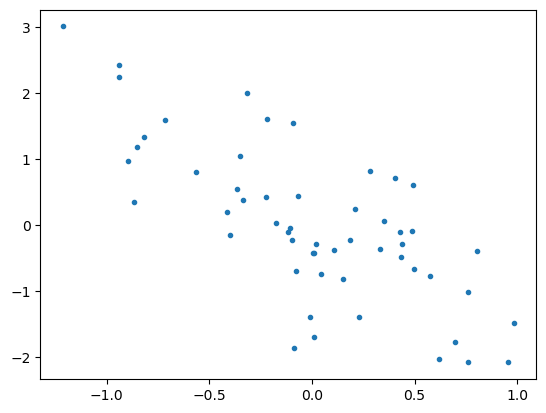

In [139]:
plt.plot(x,y1,'.')

In [71]:
mdls=['CESM1','CESM2','MPIGE','MPI12']
y1s=[1960,1989,2073]
y2s=[1989,2018,2099]
m={mdl:{y1:get5000(mdl,y1,y2) for y1,y2 in zip(y1s,y2s)} for mdl in mdls}

In [72]:
m5={}
for mdl in mdls:
    m5[mdl]={}
    for y1 in y1s:
        nens=len(m[mdl][y1])
        nper=int(5000/nens)
        m5[mdl][y1]=np.array([x[:nper] for x in m[mdl][y1]]).ravel()


In [80]:
mdl='CESM2'
for i in range(2):
    for j in range(i+1,3):
        a=y1s[i]
        b=y1s[j]
        f,p=stats.wilcoxon(m5[mdl][a],m5[mdl][b])
        print(mdl,a,b,np.round(p,5))

CESM2 1960 1989 0.0
CESM2 1960 2073 0.0
CESM2 1989 2073 0.0


In [128]:
mdl='MPI12'
ees=list(np.arange(30).astype(int))
a=1989
b=2073

nx=1
nper=int(5000/nx)

if nx>1:
    ees=[(random.sample(range(30),nx),random.sample(range(30),nx)) for i in range(900)]
else:
    ees=[([e1],[e2]) for e1 in range(30) for e2 in range(30)]
    
pvals=[]
for ee in ees:

    xa=np.array([m[mdl][a][e][:nper] for e in ee[0]]).ravel()
    xb=np.array([m[mdl][b][e][:nper] for e in ee[1]]).ravel()


    f,p=stats.ttest_ind(xa,xb)
    pvals.append(p)


In [129]:
(np.array(pvals)<0.05).sum()

892

In [74]:
y1=1960
y2=1989
v='NEE'
xas={}
yas={}
for mdl in mdls:
    la=las[mdl]
    latrop=la*(abs(la.lat)<24)
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    ix=get_ix(ds,y1,y2)
    xa=1e-9*(latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year'))
    ya=1e-9*24*60*60*365*(la.sum()*detrend_dim(ds[v].isel(year=ix),'year'))
    xas[mdl]=xa
    yas[mdl]=ya

CESM1 0.654 0.437 1.498
CESM2 0.179 0.122 1.468
MPIGE 0.53 0.358 1.48
MPI12 0.378 0.269 1.407


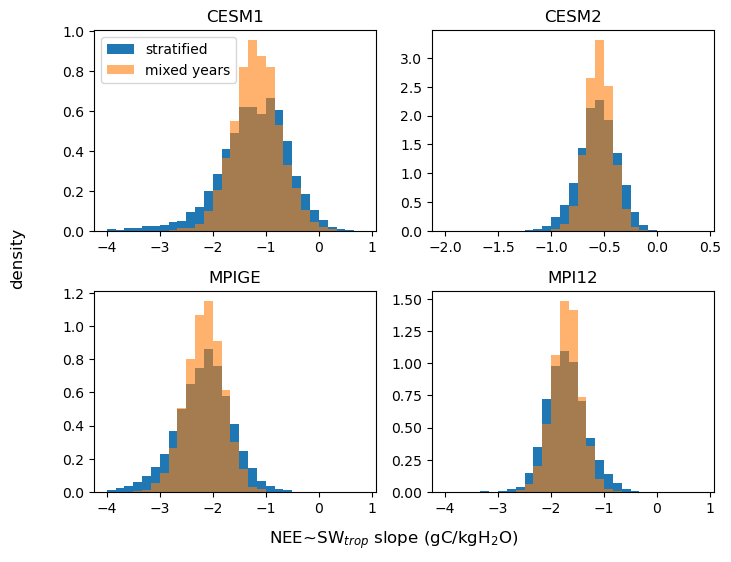

In [121]:
fig=plt.figure(figsize=[8,6])
for j,mdl in enumerate(mdls):
    plt.subplot(2,2,j+1)

    nens=len(xas[mdl].ens)
    nr=int(5000/nens)
    nr+=(nr<5000/nens)

    if j==1:
        bins=np.arange(-2,0.5,1/12)
    else:
        bins=np.arange(-4,1,1/6)
    
    x=xas[mdl]
    y=yas[mdl]
    m0=[]
    for ee in range(nens):
        for i in range(nr):
            ixr=np.random.randint(27,size=27)
            m0.append(stats.linregress(x.isel(ens=ee,year=ixr),y.isel(ens=ee,year=ixr))[0])

    x=xas[mdl].stack({'ensyear':['ens','year']})
    y=yas[mdl].stack({'ensyear':['ens','year']})
    n=len(x)
    m1=[]
    for i in range(nens*nr):
        ixr=np.random.randint(n,size=27)
        m1.append(stats.linregress(x.isel(ensyear=ixr),y.isel(ensyear=ixr))[0])


    plt.hist(m0,bins=bins,density=True,label='stratified')
    plt.hist(m1,bins=bins,alpha=0.6,density=True,label='mixed years');
    plt.title(mdl)
    if j==0:
        plt.legend()
        
    s1=np.std(m0)
    s2=np.std(m1)
    print(mdl,
          np.round(s1,3),
          np.round(s2,3),
          np.round(s1/s2,3))
plt.subplots_adjust(hspace=0.3)
fig.supxlabel('NEE~SW$_{trop}$ slope (gC/kgH$_2$O)')
fig.supylabel('density')
plt.savefig('../figs/supp/stratify_1960_1989.png',dpi=300,bbox_inches='tight')

In [163]:
def getn(xa,ya,n):
    m=[]
    for i in range(n):
            ixr=np.random.randint(27,size=27)
            m.append(stats.linregress(xa.isel(year=ixr),
                                      ya.isel(year=ixr))[0])
    return m

In [133]:
def get5000(mdl,y1,y2):

    la=las[mdl]
    latrop=la*(abs(la.lat)<24)
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    ix=get_ix(ds,y1,y2)
    xa=1e-9*(latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year'))
    ya=1e-9*24*60*60*365*(la.sum()*detrend_dim(ds[v].isel(year=ix),'year'))
    nens=len(ds.ens)
    nper=int(5000/nens)
    m=[]
    for ee in range(nens):
        for i in range(nper):
            ixr=np.random.randint(27,size=27)
            m.append(stats.linregress(xa.isel(ens=ee,year=ixr),
                                      ya.isel(ens=ee,year=ixr))[0])
    return m

In [157]:
mdl='MPI12'
y1a,y2a=1960,1989
y1b,y2b=1989,2018

la=las[mdl]
latrop=la*(abs(la.lat)<24)
f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
ds=xr.open_dataset(f)

ixa=get_ix(ds,y1a,y2a)
xa=1e-9*(latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ixa),'year'))
ya=1e-9*24*60*60*365*(la.sum()*detrend_dim(ds[v].isel(year=ixa),'year'))


ixb=get_ix(ds,y1b,y2b)
xb=1e-9*(latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ixb),'year'))
yb=1e-9*24*60*60*365*(la.sum()*detrend_dim(ds[v].isel(year=ixb),'year'))

In [175]:
%%time
ixs=np.random.randint(27,size=[5000,27])
ee=0
for ix in ixs:
    m=stats.linregress(xa.isel(ens=ee,year=ix),
                     ya.isel(ens=ee,year=ix))[0]

CPU times: user 3 s, sys: 2.52 ms, total: 3.01 s
Wall time: 3.11 s


In [190]:
ms={m:{y:[] for y in y1s} for m in mdls} 
ms

{'CESM1': {1960: [], 1989: [], 2073: []},
 'CESM2': {1960: [], 1989: [], 2073: []},
 'MPIGE': {1960: [], 1989: [], 2073: []},
 'MPI12': {1960: [], 1989: [], 2073: []}}

In [191]:
for mdl in mdls:
    for y1,y2 in zip(y1s,y2s):

        print(mdl,y1)
        la=las[mdl]
        latrop=la*(abs(la.lat)<24)
        f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
        ds=xr.open_dataset(f)
        ix=get_ix(ds,y1,y2)
        xa=1e-9*(latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year'))
        ya=1e-9*24*60*60*365*(la.sum()*detrend_dim(ds[v].isel(year=ix),'year'))


        for ee in ds.ens:
            ixs=xr.DataArray(np.random.randint(27,size=[5000,27]),dims=['draw','year'])
            xs=xa.isel(ens=ee,year=ixs)
            ys=ya.isel(ens=ee,year=ixs)
            m=[stats.linregress(x,y)[0] for x,y in zip(xs,ys)]
            ms[mdl][y1].append(m)

CESM1 1960
CESM1 1989
CESM1 2073
CESM2 1960
CESM2 1989
CESM2 2073
MPIGE 1960
MPIGE 1989
MPIGE 2073
MPI12 1960
MPI12 1989
MPI12 2073


In [ ]:
mdl=

In [167]:
%%time
ee=0
m=getn(xa.sel(ens=ee),
       ya.sel(ens=ee),
       5000)

CPU times: user 2.37 s, sys: 2.69 ms, total: 2.37 s
Wall time: 2.43 s


In [159]:
nens=len(ds.ens)
pvals=[]
for i in range(100):
    if i%10==0:
        print(i)
    eea=np.random.randint(nens)
    eeb=np.random.randint(nens)
    ma=getn(xa,ya,5000,eea)
    mb=getn(xb,yb,5000,eeb)
    pvals.append(stats.wilcoxon(ma,mb)[1])

    

0
10
20


KeyboardInterrupt: 

In [156]:
pvals

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [136]:
y1s=[1960,1989,2073]
y2s=[1989,2018,2099]
mdl='MPI12'
m={y1:get5000(mdl,y1,y2) for y1,y2 in zip(y1s,y2s)}


In [144]:
stats.wilcoxon(m[1960],m[1989],alternative='less')


WilcoxonResult(statistic=5977012.0, pvalue=0.0135204517039262)

In [141]:
p

0.0270409034078524

In [71]:
y1s=[1960,1989,2073]
y2s=[1989,2018,2099]
v='NEE'
m={}
for mdl in mdls:
    m[mdl]={}
    la=las[mdl]
    latrop=la*(abs(la.lat)<24)
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)

    for y1,y2 in zip(y1s,y2s):
        ix=get_ix(ds,y1,y2)
        xa=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
        ya=1e-9*24*60*60*365*la.sum()*detrend_dim(ds[v].isel(year=ix),'year')
        m[mdl][y1]=[stats.linregress(xa.sel(ens=ee),ya.sel(ens=ee))[0] for ee in ds.ens]

In [72]:
print('  '+v+'~TWS: 5th-95th')
print('----------------------')
for mdl in m:
    for y1 in m[mdl]:
        print(mdl,y1,np.round(np.quantile(m[mdl][y1],0.05),2),np.round(np.quantile(m[mdl][y1],0.95),2))

  NEE~TWS: 5th-95th
----------------------
CESM1 1960 -1.87 -0.61
CESM1 1989 -2.14 -0.62
CESM1 2073 -1.97 -0.45
CESM2 1960 -0.8 -0.35
CESM2 1989 -0.88 -0.39
CESM2 2073 -0.64 -0.15
MPIGE 1960 -2.94 -1.61
MPIGE 1989 -2.61 -1.44
MPIGE 2073 -2.39 -0.98
MPI12 1960 -2.05 -1.34
MPI12 1989 -2.06 -1.3
MPI12 2073 -1.5 -0.93


In [80]:
print('  '+v+'~TWS: mean')
print('----------------------')
for mdl in m:
    for y1 in m[mdl]:
        print(mdl,y1,np.round(np.mean(m[mdl][y1]),2))

  NEE~TWS: mean
----------------------
CESM1 1960 -1.23
CESM1 1989 -1.17
CESM1 2073 -1.11
CESM2 1960 -0.56
CESM2 1989 -0.62
CESM2 2073 -0.39
MPIGE 1960 -2.18
MPIGE 1989 -2.03
MPIGE 2073 -1.68
MPI12 1960 -1.7
MPI12 1989 -1.7
MPI12 2073 -1.18


In [86]:
for mdl in m:
    for i in range(3):
        c=''
        for j in range(i):
            f,p=stats.ttest_ind(m[mdl][y1s[i]],m[mdl][y1s[j]])
            if p<0.05:
                c=c+'*'
            else:
                c=c+'='
        print(mdl,str(y1s[i])+'-'+str(y2s[i]),str(np.round(np.mean(m[mdl][y1s[i]]),2)).rjust(7),c)

CESM1 1960-1989   -1.23 
CESM1 1989-2018   -1.17 =
CESM1 2073-2099   -1.11 ==
CESM2 1960-1989   -0.56 
CESM2 1989-2018   -0.62 *
CESM2 2073-2099   -0.39 **
MPIGE 1960-1989   -2.18 
MPIGE 1989-2018   -2.03 *
MPIGE 2073-2099   -1.68 **
MPI12 1960-1989    -1.7 
MPI12 1989-2018    -1.7 =
MPI12 2073-2099   -1.18 **


In [ ]:
for x in m:
    for yy in m[x]:
        c=''
        for j in range(i):
            f,p=stats.ttest_ind(m[x][yy],xs[x][j])
            if p<0.05:
                c=c+'*'
            else:
                c=c+'='
        print(x,str(y1s[i])+'-'+str(y2s[i]),str(np.round(np.mean(xs[x][i]),3)).rjust(7),c)

In [76]:
stats.ttest_ind(m['CESM1'][1960],m['CESM1'][1989])

TtestResult(statistic=-0.5235539784467614, pvalue=0.6020731655369634, df=78.0)

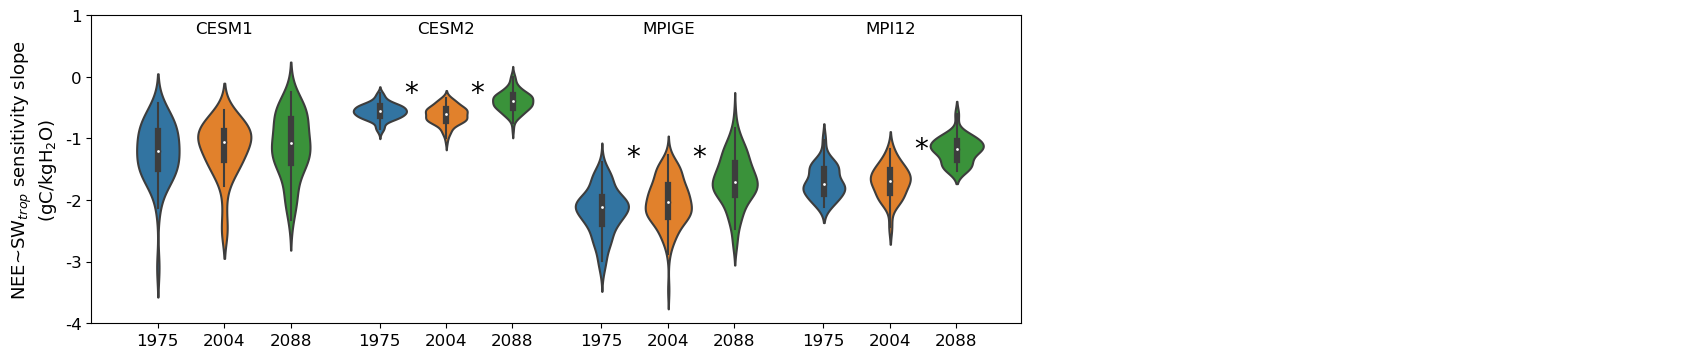

In [73]:


fig, ax1 = plt.subplots(ncols=1,figsize=[12,4])

xshift=0.185
for i,mdl in enumerate(mdls):
    ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
    pos = ax.get_position()
    newpos = Bbox.from_bounds(pos.x0+i*xshift, pos.y0, pos.width, pos.height)
    ax.set_position(newpos)
    ax.axis('off')
    
    sns.violinplot(pd.DataFrame(m[mdl]),ax=ax)
    
    plt.text(1,0.7,mdl,ha='center',fontsize=12)
    
    for i in range(2):
        f,p=stats.ttest_ind(m[mdl][y1s[i]],m[mdl][y1s[i+1]])
        if p<0.05:
            plt.text(0.367+i,np.quantile(m[mdl][1989],0.95),'*',fontsize=20)
    
plt.xlim([-1,13])

xv=[i*3.338+j for i in range(4) for j in range(3)]
ax1.set_yticks(range(-4,2),range(-4,2),fontsize=12);
ax1.set_xticks(xv,np.tile(np.array(y1s)+15,4),fontsize=12);
ax1.set_ylabel(v+'~SW$_{trop}$ sensitivity slope \n(gC/kgH$_2$O)',fontsize=13);

#plt.savefig('../figs/main/violins_nee_swtrop.png',dpi=300,bbox_inches='tight')

In [68]:
print(' '+v+'~TWS: mean')
print('----------------')
for mdl in m:
    for y in m[mdl]:
        print(mdl,y,np.round(np.mean(m[mdl][y]),2))

 NEE~TWS: mean
----------------
CESM1 1960 -1.23
CESM1 1989 -1.17
CESM1 2073 -1.11
CESM2 1960 -0.56
CESM2 1989 -0.62
CESM2 2073 -0.39
MPIGE 1960 -2.18
MPIGE 1989 -2.03
MPIGE 2073 -1.68
MPI12 1960 -1.7
MPI12 1989 -1.7
MPI12 2073 -1.18


### Supp Figure 1

In [6]:
y1s=[1960,1989,2073]
y2s=[1989,2018,2099]
v='NBP'
m={}
for mdl in mdls:
    m[mdl]={}
    la=las[mdl]
    latrop=la*(abs(la.lat)<24)
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)

    for y1,y2 in zip(y1s,y2s):
        ix=get_ix(ds,y1,y2)
        xa=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
        ya=1e-9*24*60*60*365*la.sum()*detrend_dim(ds[v].isel(year=ix),'year')
        m[mdl][y1]=[stats.linregress(xa.sel(ens=ee),ya.sel(ens=ee))[0] for ee in ds.ens]

In [46]:
import Nio

ModuleNotFoundError: No module named 'Nio'

In [47]:
f='/glade/work/linnia/CLM-PPE-LAI_tests/FUNbug/paramfiles/FUNbug0001.nc'

In [52]:
p=xr.open_dataset(f)

In [58]:
for pft,kc in zip(p.pftname,p.kc_nonmyc):
    print(str(pft.values)[2:-1],np.round(kc.values,3))

not_vegetated                            0.0
needleleaf_evergreen_temperate_tree      0.012
needleleaf_evergreen_boreal_tree         0.012
needleleaf_deciduous_boreal_tree         0.001
broadleaf_evergreen_tropical_tree        0.012
broadleaf_evergreen_temperate_tree       0.012
broadleaf_deciduous_tropical_tree        0.001
broadleaf_deciduous_temperate_tree       0.012
broadleaf_deciduous_boreal_tree          0.012
broadleaf_evergreen_shrub                0.012
broadleaf_deciduous_temperate_shrub      0.012
broadleaf_deciduous_boreal_shrub         0.012
c3_arctic_grass                          0.012
c3_non-arctic_grass                      0.012
c4_grass                                 0.12
c3_crop                                  0.012
c3_irrigated                             0.012
temperate_corn                           0.12
irrigated_temperate_corn                 0.12
spring_wheat                             0.012
irrigated_spring_wheat                   0.012
winter_wheat      

In [45]:
print('  '+v+'~TWS: 5th-95th')
print('----------------------')
for mdl in m:
    for y1 in m[mdl]:
        print(mdl,y1,np.round(np.quantile(m[mdl][y1],0.05),2),np.round(np.quantile(m[mdl][y1],0.95),2))

  NEE~TWS: 5th-95th
----------------------
CESM1 1960 -1.87 -0.61
CESM1 1989 -2.14 -0.62
CESM1 2073 -1.97 -0.45
CESM2 1960 -0.8 -0.35
CESM2 1989 -0.88 -0.39
CESM2 2073 -0.64 -0.15
MPIGE 1960 -2.94 -1.61
MPIGE 1989 -2.61 -1.44
MPIGE 2073 -2.39 -0.98
MPI12 1960 -2.05 -1.34
MPI12 1989 -2.06 -1.3
MPI12 2073 -1.5 -0.93


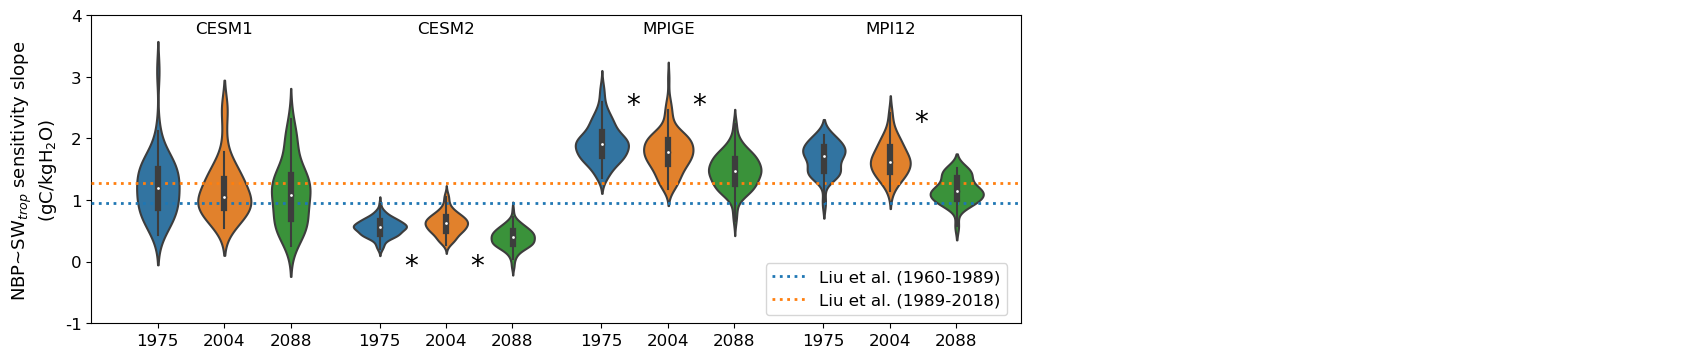

In [40]:


fig, ax1 = plt.subplots(ncols=1,figsize=[12,4])

xshift=0.185
for i,mdl in enumerate(mdls):
    ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
    pos = ax.get_position()
    newpos = Bbox.from_bounds(pos.x0+i*xshift, pos.y0, pos.width, pos.height)
    ax.set_position(newpos)
    ax.axis('off')
    plt.plot([-1,2.3+0.65*(i==3)],[0.95,0.95],'C0:',lw=2,label='Liu et al. (1960-1989)')
    plt.plot([-1,2.3+0.65*(i==3)],[1.27,1.27],'C1:',lw=2,label='Liu et al. (1989-2018)')
    if mdl=='MPI12':
        plt.legend(loc=3,fontsize=12)
    sns.violinplot(pd.DataFrame(m[mdl]),ax=ax)
    
    plt.text(1,3.7,mdl,ha='center',fontsize=12)
    
    for i in range(2):
        f,p=stats.ttest_ind(m[mdl][y1s[i]],m[mdl][y1s[i+1]])
        if p<0.05:
            if mdl=='CESM2':
                plt.text(0.367+i,-0.2,'*',fontsize=20)
            else:
                plt.text(0.367+i,np.quantile(m[mdl][1989],0.95),'*',fontsize=20)
    
plt.xlim([-1,13])

xv=[i*3.338+j for i in range(4) for j in range(3)]
ax1.set_yticks(range(-1,5),range(-1,5),fontsize=12);
ax1.set_xticks(xv,np.tile(np.array(y1s)+15,4),fontsize=12);
ax1.set_ylabel(v+'~SW$_{trop}$ sensitivity slope \n(gC/kgH$_2$O)',fontsize=13);

plt.savefig('../figs/main/violins_nbp_swtrop.png',dpi=300,bbox_inches='tight')

In [68]:
print(' '+v+'~TWS: mean')
print('----------------')
for mdl in m:
    for y in m[mdl]:
        print(mdl,y,np.round(np.mean(m[mdl][y]),2))

 NEE~TWS: mean
----------------
CESM1 1960 -1.23
CESM1 1989 -1.17
CESM1 2073 -1.11
CESM2 1960 -0.56
CESM2 1989 -0.62
CESM2 2073 -0.39
MPIGE 1960 -2.18
MPIGE 1989 -2.03
MPIGE 2073 -1.68
MPI12 1960 -1.7
MPI12 1989 -1.7
MPI12 2073 -1.18


In [51]:
np.mean(m['CESM2'][2073]),np.mean(m['CESM2'][1989])

(-0.3944592309385094, -0.6169069242586492)

In [49]:
stats.ttest_ind(m['CESM2'][1960],m['CESM2'][1989])

TtestResult(statistic=2.888141093827157, pvalue=0.004306342279048309, df=198.0)

In [177]:
ds=xr.open_dataset('/glade/scratch/djk2120/postp/twsnbp/cesm2.labeled.nc')
ixt=get_ix(ds,1960,1989)
la=las['CESM2']
latrop=la*(abs(la.lat)<24)
x=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ixt),'year')
y=1e-9*la.sum()*24*60*60*365*detrend_dim(ds.NEE.isel(year=ixt),'year')

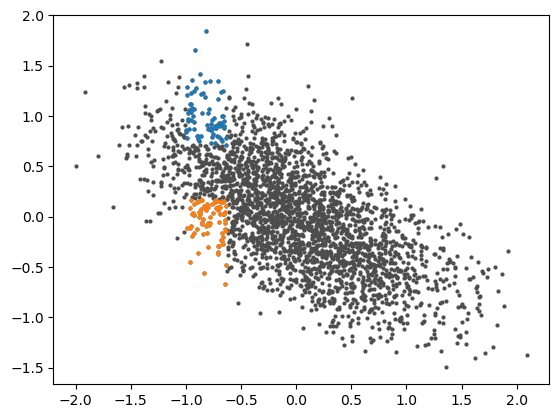

In [178]:
ix0=(x>-1)&(x<-0.633)
q1,q2=np.quantile(y.values[ix],[0.25,0.75])
ix2=(ix0)&(y<q1)
ix1=(ix0)&(y>q2)

plt.plot(x,y,'.',color=0.3*np.ones(3),ms=4);
plt.plot(x.where(ix1),y.where(ix1),'C0.',ms=4);
plt.plot(x.where(ix2),y.where(ix2),'C1.',ms=4);

In [61]:
def pp(ds):
    return ds.isel(year=ixt)

In [ ]:
cmap=plt.get_cmap('RdBu', 15)

In [181]:
def get_swix(x,y,ix):
    xx=x.where(ix).stack({'ensyear':['ens','year']}).dropna(dim='ensyear')
    yy=y.where(ix).stack({'ensyear':['ens','year']}).dropna(dim='ensyear')
    d='/glade/scratch/djk2120/postp/twsnbp/'
    files=[d+ee.replace('postp','gridded') for ee in xx.ens.values]
    ds=xr.open_mfdataset(files,combine='nested',concat_dim='ens',parallel=True,preprocess=pp)
    swa=la*1e-6*detrend_dim(ds.SW,'year').compute()
    sws=[swa.sel(ens=i,year=xx.year[i]) for i in range(len(xx))]
    sw=xr.concat(sws,dim='ensyear').mean(dim='ensyear')
    
    return sw,xx,yy

In [182]:
sw1,xx1,yy1=get_swix(x,y,ix1)

In [183]:
sw2,xx2,yy2=get_swix(x,y,ix2)

In [189]:
yy1.mean()-yy2.mean()

<xarray.DataArray ()>
array(1.05261301)

In [231]:
def swplot(sw,ax,sub='High',delt='',vv=None):
    if vv:
        sw.plot(cmap=cmap,cbar_kwargs={'label':delt+'SW anomaly (GtH$_2$O)'},vmin=-vv,vmax=vv,ax=ax);
    else:
        sw.plot(cmap=cmap,cbar_kwargs={'label':delt+'SW anomaly (GtH$_2$O)'},ax=ax);
    ax.set_title(sub+' NEE composite')
    ax.set_ylim([-60,90])
    ax.set_xticks(60*np.arange(7))
    ax.set_yticks(-60+30*np.arange(6))
    ax.set_xlabel('')
    ax.set_ylabel('');

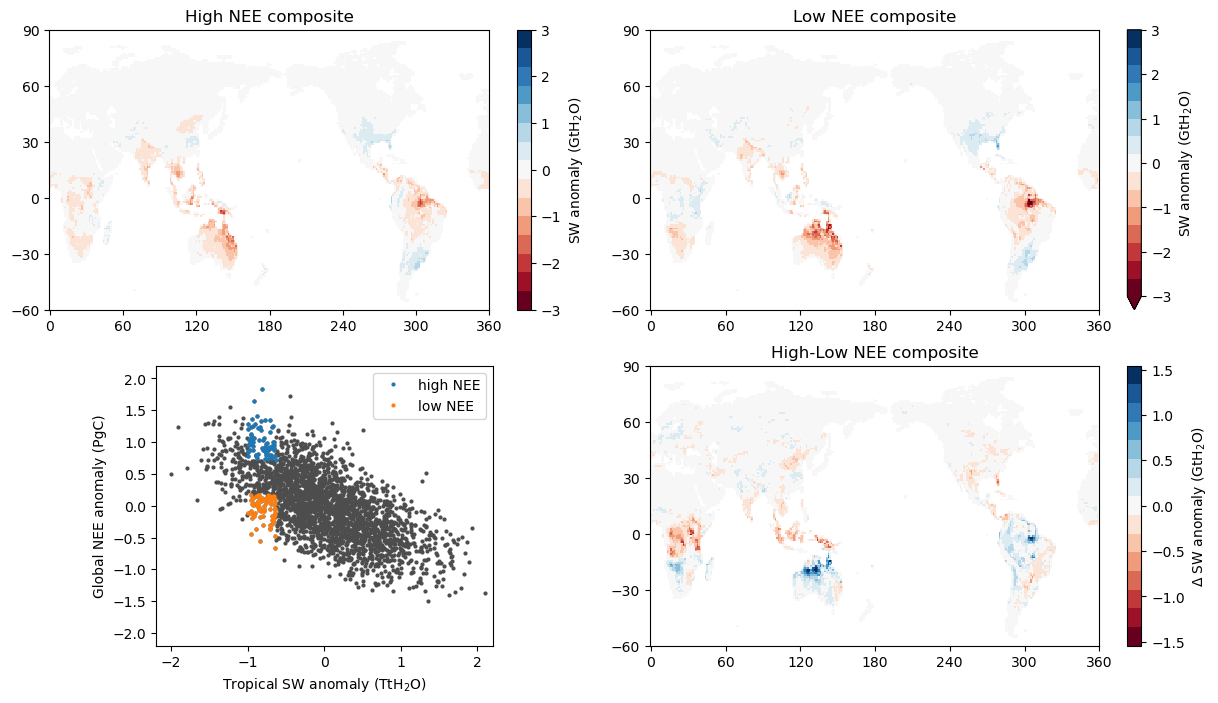

In [237]:
fig = plt.figure(figsize=[15,8])
axs = fig.subplot_mosaic('AAAB;CDEF',gridspec_kw={'height_ratios': [1,1],'width_ratios': [0.1,0.6,0.1,1]})
axs['C'].set_axis_off()
axs['E'].set_axis_off()


swplot(sw1,axs['A'],vv=3)
swplot(sw2,axs['B'],sub='Low',vv=3)
swplot(sw1-sw2,axs['F'],'High-Low',r'$\Delta$ ')

ax=axs['D']
ax.plot(-100,0,'C0.',ms=4,label='high NEE');
ax.plot(-100,0,'C1.',ms=4,label='low NEE');
ax.legend()
ax.plot(x,y,'.',color=0.3*np.ones(3),ms=4,label='all data');
ax.plot(x.where(ix1),y,'C0.',ms=4,label='high NEE');
ax.plot(x.where(ix2),y,'C1.',ms=4,label='low NEE');
ax.set_xlim([-2.2,2.2])
ax.set_ylim([-2.2,2.2])
ax.set_xlabel('Tropical SW anomaly (TtH$_2$O)')
ax.set_ylabel('Global NEE anomaly (PgC)')

plt.savefig('../figs/main/nee_composite_maps_cesm2.png',dpi=300,bbox_inches='tight')


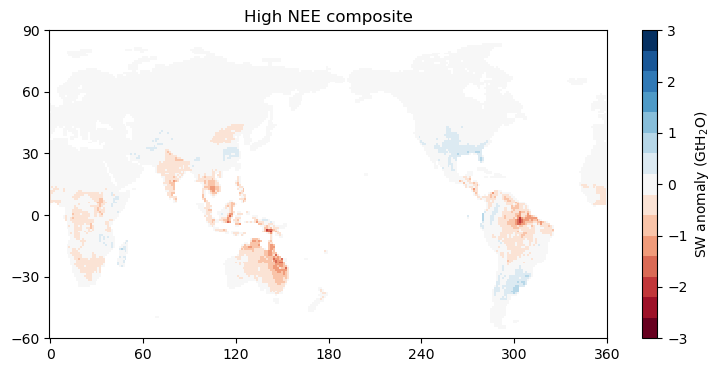

In [202]:
plt.figure(figsize=[9,4])
swplot(sw1,vv=3)

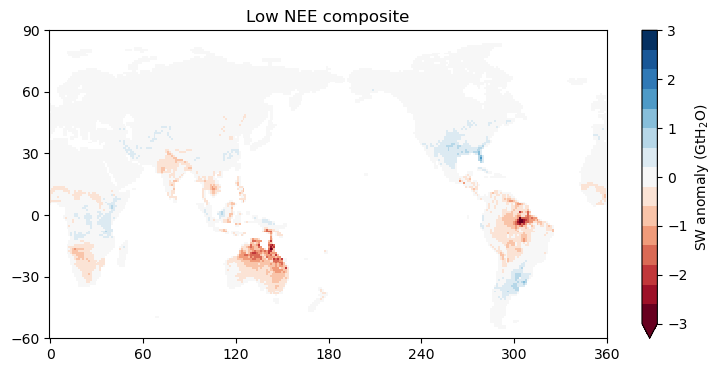

In [203]:
plt.figure(figsize=[9,4])
swplot(sw2,'Low',vv=3)

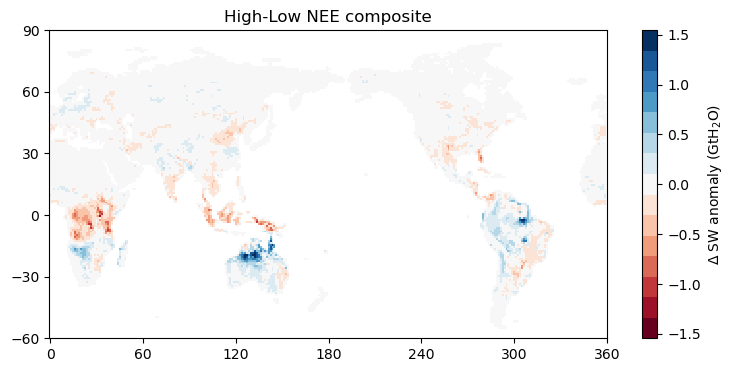

In [205]:
plt.figure(figsize=[9,4])
swplot(sw1-sw2,'High-Low',r'$\Delta$ ')

In [8]:
mdl='CESM2'
f='/glade/scratch/djk2120/postp/twsnbp/cesm2.labeled.nc'
ds=xr.open_dataset(f)
la=las[mdl]
latrop=la*(abs(la.lat)<24)

In [9]:
ix=get_ix(ds,1960,1989)
x=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
y=1e-9*la.sum()*24*60*60*365*detrend_dim(ds.NEE.isel(year=ix),'year')


In [10]:
m,b,r,p,err=stats.linregress(x.values.ravel(),y.values.ravel())

In [11]:
resids=y-m*x-b

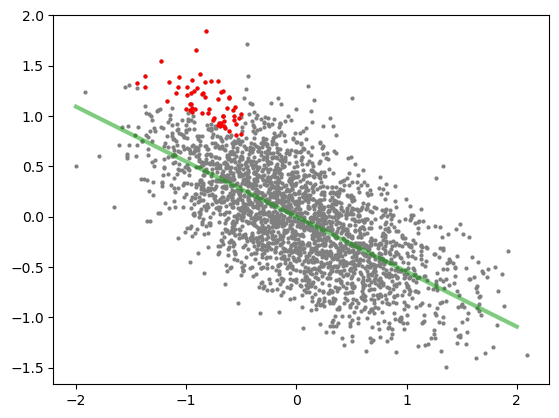

(-60.0, 90.0)

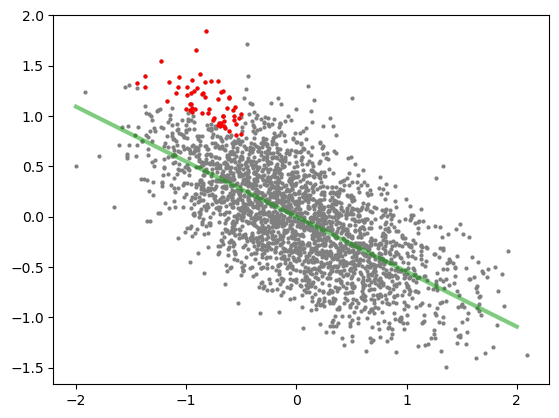

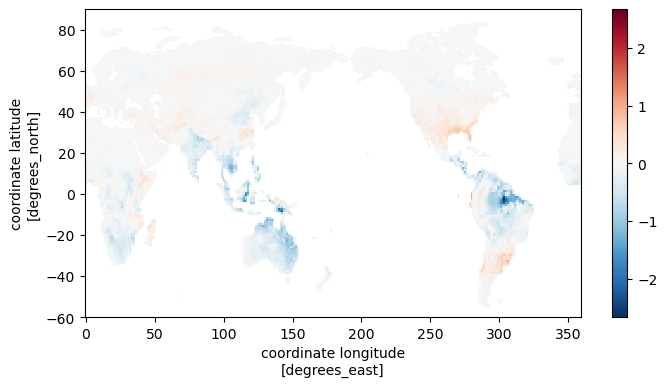

In [59]:
r=0.5
ix=((resids>r)&(x<-0.5))
ees=np.tile(x.ens.values.reshape([-1,1]),[1,27])[ix]
yys=np.tile(x.year,[100,1])[ix]
files=[getmem(ee,yy) for ee,yy in zip(ees,yys)]

plt.plot(x,y,'.',color=0.5*np.ones(3),ms=4);
plt.plot(x.where(ix),y.where(ix),'r.',ms=4)
xv=np.array([-2,2])
plt.plot(xv,m*xv+b,color=[0,0.6,0],lw=3,alpha=0.5)



d='/glade/scratch/djk2120/postp/twsnbp/'
sws=[]
for ee,yy in zip(ees,yys):
    f=d+ee.replace('postp','gridded')
    ds=xr.open_dataset(f)
    sw=1e-6*la*detrend_dim(ds.SW.isel(year=ixt),'year').sel(year=yy)
    sws.append(sw)
 
plt.figure(figsize=[8,4])
da=xr.concat(sws,dim='ensyear')
da.mean(dim='ensyear').where(la>0).plot()
plt.ylim([-60,90])

(-60.0, 90.0)

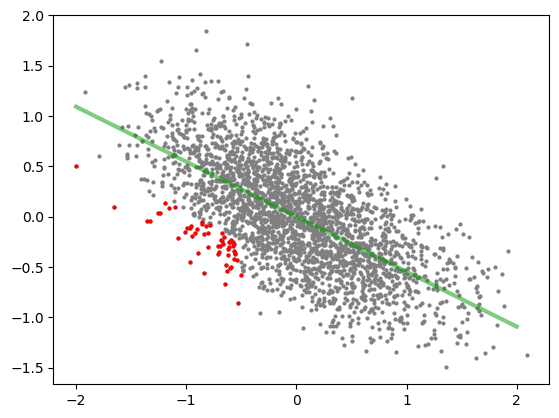

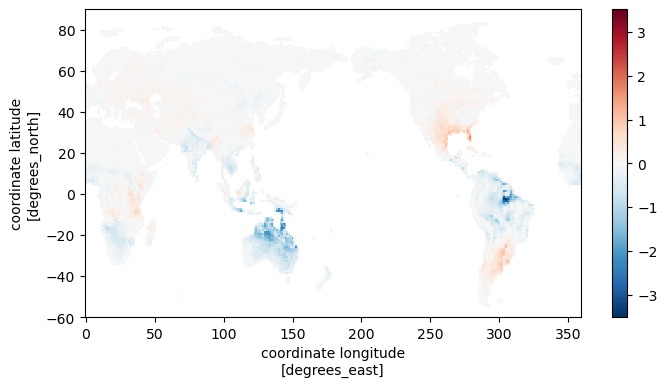

In [60]:
r=0.5
ix=((resids<-r)&(x<-0.5))
ees=np.tile(x.ens.values.reshape([-1,1]),[1,27])[ix]
yys=np.tile(x.year,[100,1])[ix]
files=[getmem(ee,yy) for ee,yy in zip(ees,yys)]

plt.plot(x,y,'.',color=0.5*np.ones(3),ms=4);
plt.plot(x.where(ix),y.where(ix),'r.',ms=4)
xv=np.array([-2,2])
plt.plot(xv,m*xv+b,color=[0,0.6,0],lw=3,alpha=0.5)



d='/glade/scratch/djk2120/postp/twsnbp/'
sws=[]
for ee,yy in zip(ees,yys):
    f=d+ee.replace('postp','gridded')
    ds=xr.open_dataset(f)
    sw=1e-6*la*detrend_dim(ds.SW.isel(year=ixt),'year').sel(year=yy)
    sws.append(sw)
 
plt.figure(figsize=[8,4])
da=xr.concat(sws,dim='ensyear')
da.mean(dim='ensyear').where(la>0).plot()
plt.ylim([-60,90])

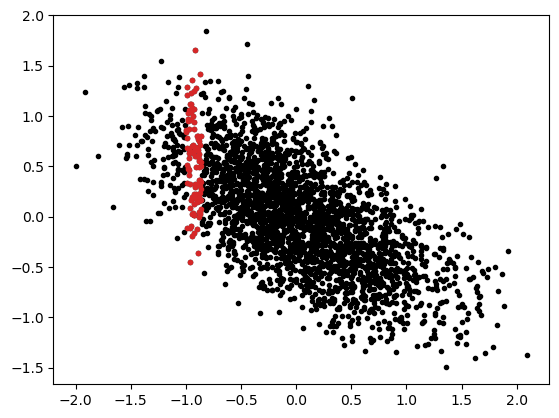

In [122]:
ix=(x>-1)&(x<-0.86)
plt.plot(x,y,'k.');
plt.plot(x.where(ix),y.where(ix),'C'+str(i)+'.');

In [97]:
ees=np.tile(x.ens.values.reshape([-1,1]),[1,27])[ix]
yys=np.tile(x.year,[100,1])[ix]

In [120]:
sws=[]
for ee,yy in zip(ees,yys):
    f=d+ee.replace('postp','gridded')
    ds=xr.open_dataset(f)
    sw=detrend_dim(1e-9*(laaus*ds.SW).sum(dim=['lat','lon']),'year').sel(year=yy)
    sws.append(sw)

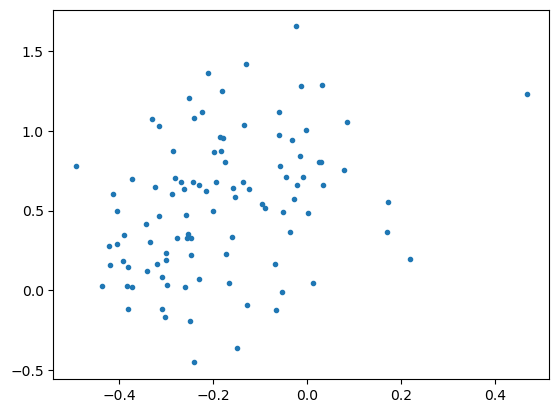

In [123]:
plt.plot(sws,y.values[ix],'.')

In [88]:
c=regionmask.defined_regions.natural_earth_v5_0_0.countries_110
mask = c.mask(ds.lon,ds.lat)
ixaus=(mask==137)
laaus=ixaus*la

In [127]:
((x>-1)&(x<-0.5)).sum()

<xarray.DataArray ()>
array(471)

In [132]:
ix1=(y>0.8)&(x>-1)&(x<-0.5)
ix2=(y<0)&(x>-1)&(x<-0.5)
das=[]
for ix in [ix1,ix2]:
    d='/glade/scratch/djk2120/postp/twsnbp/'
    
    ees=np.tile(x.ens.values.reshape([-1,1]),[1,27])[ix]
    yys=np.tile(x.year,[100,1])[ix]
    files=[getmem(ee,yy) for ee,yy in zip(ees,yys)]
    
    sws=[]
    for ee,yy in zip(ees,yys):
        f=d+ee.replace('postp','gridded')
        ds=xr.open_dataset(f)
        sw=1e-6*la*detrend_dim(ds.SW.isel(year=ixt),'year').sel(year=yy)
        sws.append(sw)
    da=xr.concat(sws,dim='ensyear')
    das.append(da)

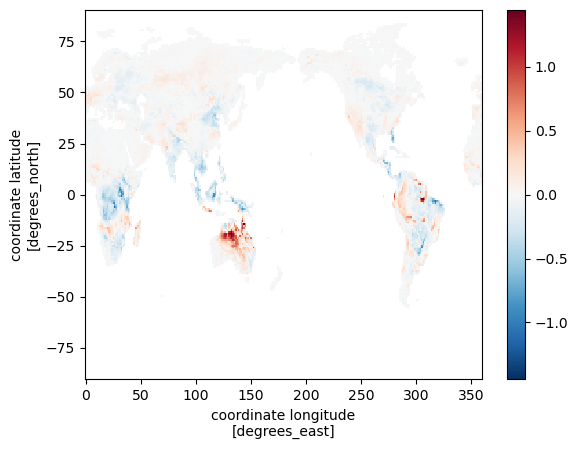

In [137]:
(das[0].mean(dim='ensyear')-das[1].mean(dim='ensyear')).plot()

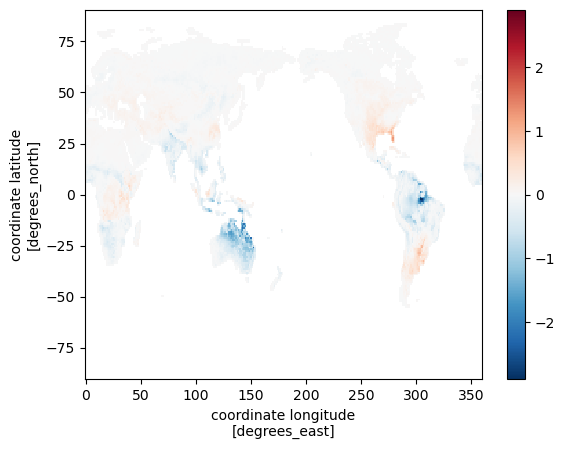

In [136]:
das[1].mean(dim='ensyear').plot()

<xarray.DataArray ()>
array(81)

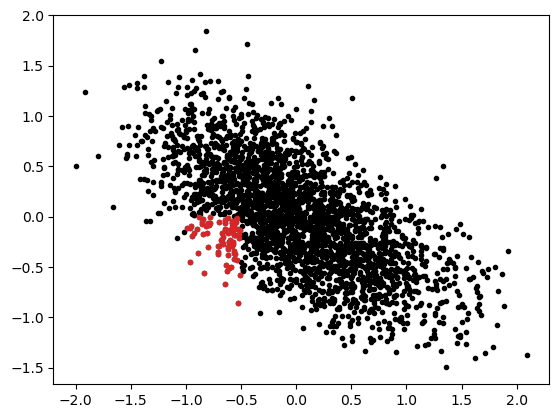

In [131]:

plt.plot(x,y,'k.');
plt.plot(x.where(ix),y.where(ix),'C'+str(i)+'.');

ix.sum()

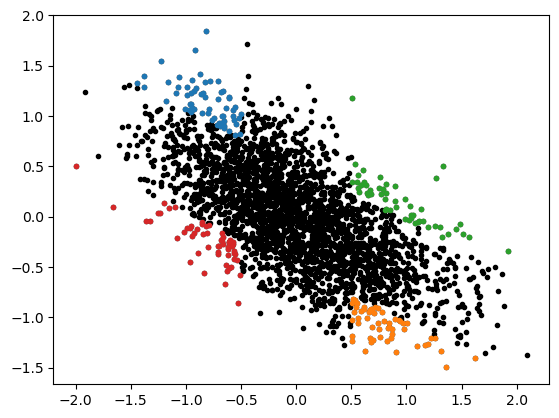

In [68]:
r=0.5
ixs=[(resids>r)&(x<-0.5),
     (resids<-r)&(x>0.5),
     (resids>r)&(x>0.5),
     (resids<-r)&(x<-0.5)]

plt.plot(x,y,'k.');
for i,ix in enumerate(ixs):
    plt.plot(x.where(ix),y.where(ix),'C'+str(i)+'.')


In [118]:
ix=(ds.lat<-10)&(ds.lat>-27)&(ds.lon>120)&(ds.lon<141)
laaus=(ix*la)

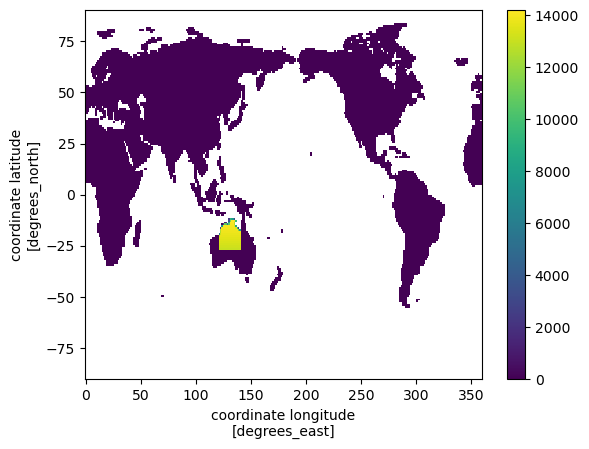

In [119]:
laaus.plot()

In [85]:
import regionmask

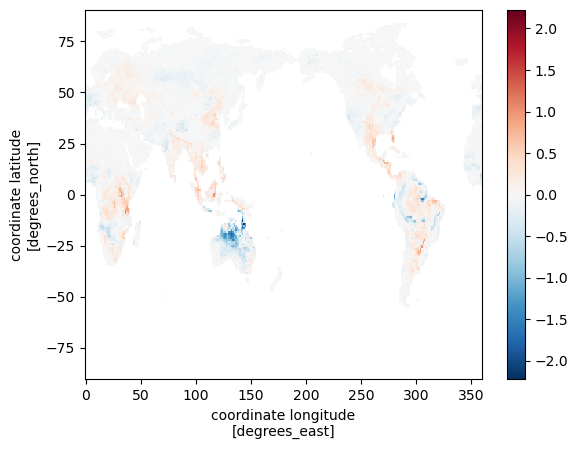

In [76]:
(out[3]-out[0]).plot()

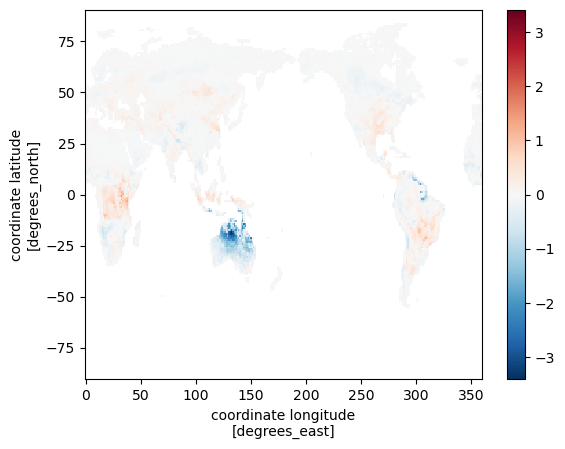

In [78]:
(out[1]-out[2]).plot()

(-60.0, 90.0)

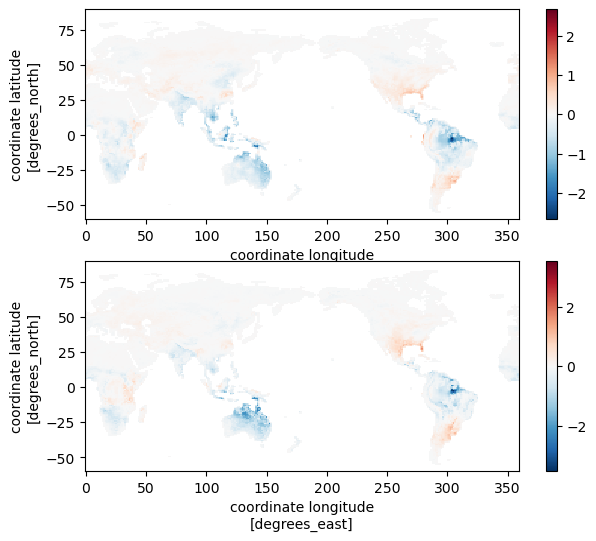

In [74]:
plt.figure(figsize=[7,6])
plt.subplot(211)
out[0].plot()
plt.ylim([-60,90])
plt.subplot(212)
out[3].plot()
plt.ylim([-60,90])

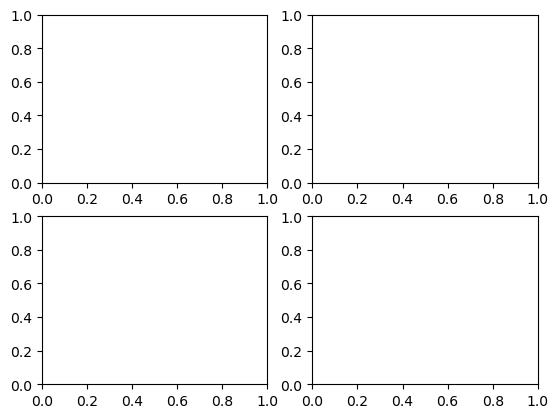

In [70]:
out=[]
for i,ix in enumerate(ixs):
    ees=np.tile(x.ens.values.reshape([-1,1]),[1,27])[ix]
    yys=np.tile(x.year,[100,1])[ix]
    files=[getmem(ee,yy) for ee,yy in zip(ees,yys)]

    d='/glade/scratch/djk2120/postp/twsnbp/'
    sws=[]
    for ee,yy in zip(ees,yys):
        f=d+ee.replace('postp','gridded')
        ds=xr.open_dataset(f)
        sw=1e-6*la*detrend_dim(ds.SW.isel(year=ixt),'year').sel(year=yy)
        sws.append(sw)


    da=xr.concat(sws,dim='ensyear')
    out.append(da.mean(dim='ensyear').where(la>0))


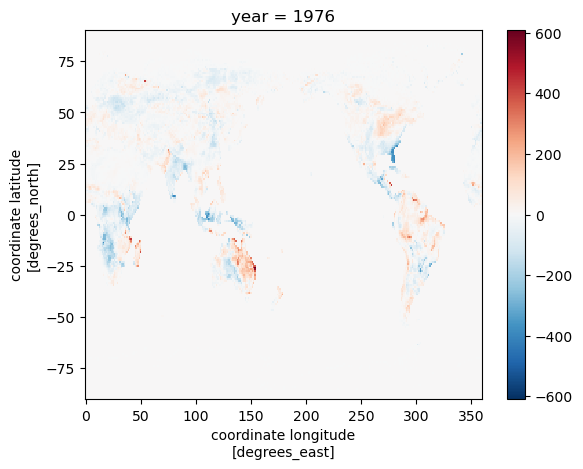

In [47]:
sw.plot()

In [25]:
ds=xr.open_mfdataset(files[0],combine='by_coords',parallel=True,preprocess=preprocess)

In [27]:
ds.TWS.isel(time

<xarray.DataArray 'TWS' (time: 480, lat: 192, lon: 288)>
dask.array<concatenate, shape=(480, 192, 288), dtype=float32, chunksize=(120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * time     (time) object 1960-01-01 00:00:00 ... 1999-12-01 00:00:00
Attributes:
    long_name:     total water storage
    units:         mm
    cell_methods:  time: mean

In [24]:
help(preprocess)

Help on function preprocess in module utils:

preprocess(ds)



In [17]:
from utils import *

In [278]:
d='/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/TWS/'
files=sorted(glob.glob(d+'*'+mem+'*'))

In [308]:

mem

'LE2-1001.001'

In [19]:
def getmem(ee,yy):
    mem=ee.split('.')[0]+'.'+ee.split('.')[1]
    files=lens_files('CESM2','TWS',yy=(yy-15,yy+15))
    ff=[]
    mm=[]
    for fs in files:
        for f in fs:
            ff.append(f)
            mm.append(f.split('.')[4]+'.'+f.split('.')[5])
    f=np.array(ff)
    m=np.array(mm)
    
    return f[m==mem]

In [153]:
for mdl in mdls:
    m[mdl]={}
    la=las[mdl]
    latrop=la*(abs(la.lat)<24)
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    
    for y1,y2 in zip(y1s,y2s):
        ix=get_ix(ds,y1,y2)
        xa=1e-9*latrop.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
        ya=1e-9*24*60*60*365*la.sum()*detrend_dim(ds.NEE.isel(year=ix),'year')
        r=np.corrcoef(xa.values.ravel(),ya.values.ravel())[0,1]
        print(mdl,y1,np.round(r,2))
    

CESM1 1960 -0.48
CESM1 1989 -0.44
CESM1 2073 -0.32
CESM2 1960 -0.66
CESM2 1989 -0.62
CESM2 2073 -0.43
MPIGE 1960 -0.77
MPIGE 1989 -0.74
MPIGE 2073 -0.7
MPI12 1960 -0.77
MPI12 1989 -0.76
MPI12 2073 -0.72


In [ ]:
fig, ax1 = plt.subplots(ncols=1,figsize=[6,8])
ax1.set(xlim=(-1, 0), ylim=(0, 40))

ax1.set_xlabel('Sensitivity slope (gC/kgH$_2$O)')
ax1.set_ylabel('density')
ax1.set_yticks([])


yshift=0.3
for i,x in enumerate(xs):
    ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
    pos = ax.get_position()
    newpos = Bbox.from_bounds(pos.x0, pos.y0+i*yshift, pos.width, pos.height)
    ax.set_position(newpos)
    ax.axis('off')
    for j in range(3):
        ax.hist(xs[x][j],alpha=0.5)

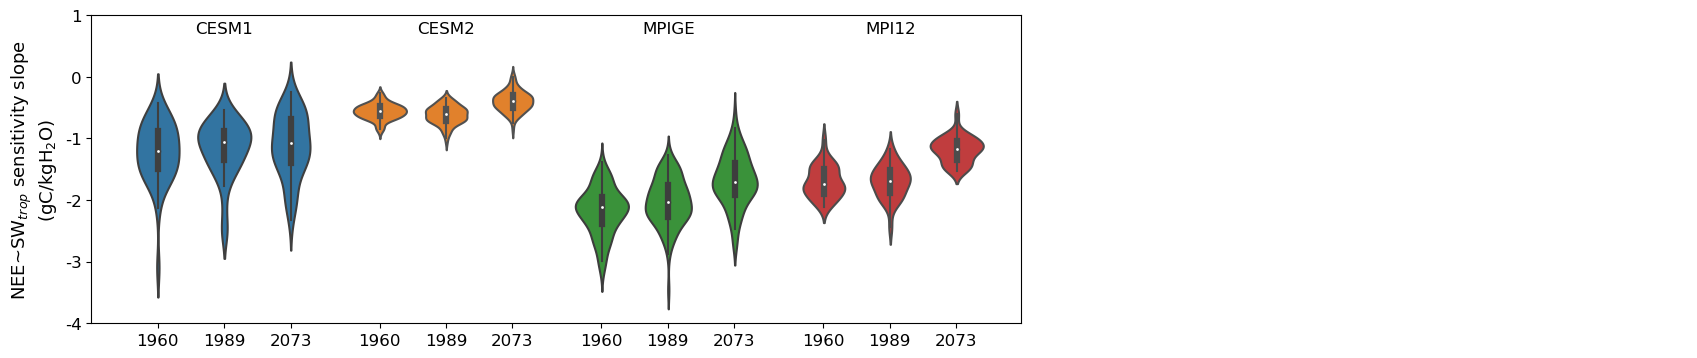

In [148]:
for mdl in mdls:
    for y in y1s:
        mx=np.round(np.mean(m[mdl][y]),2)
        sig=''
        if y==1989:
            t,p=stats.ttest_ind(m[mdl][1960],m[mdl][1960])
            if p<0.05:
                sig+='*'
            else:
                sig+='='
        if y>2000:
            for yy in [1960,1989]:
                t,p=stats.ttest_ind(m[mdl][2073],m[mdl][yy])
                if p<0.05:
                    sig+='*'
                else:
                    sig+='='
        print(mdl,y,mx,sig)

CESM1 1960 -1.23 
CESM1 1989 -1.17 =
CESM1 2073 -1.11 ==
CESM2 1960 -0.56 
CESM2 1989 -0.62 =
CESM2 2073 -0.39 **
MPIGE 1960 -2.18 
MPIGE 1989 -2.03 =
MPIGE 2073 -1.68 **
MPI12 1960 -1.7 
MPI12 1989 -1.7 =
MPI12 2073 -1.18 **


In [145]:
t,p=stats.ttest_ind(m[mdl][1960],m[mdl][1960])
p

1.0

In [183]:
def mvals(mdl,yr0,yr1):
    
    
    la=las[mdl]
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    
    ix=get_ix(ds,yr0,yr1)
    x=detrend_dim(1e-9*la.sum()*ds.SW_TROP.isel(year=ix),'year')
    y=detrend_dim(1e-9*24*60*60*365*la.sum()*ds.NEE.isel(year=ix),'year')
    m=[stats.linregress(x.sel(ens=ee),y.sel(ens=ee))[0] for ee in ds.ens]
    r=[stats.linregress(x.sel(ens=ee),y.sel(ens=ee))[2] for ee in ds.ens]
    
    return m,r

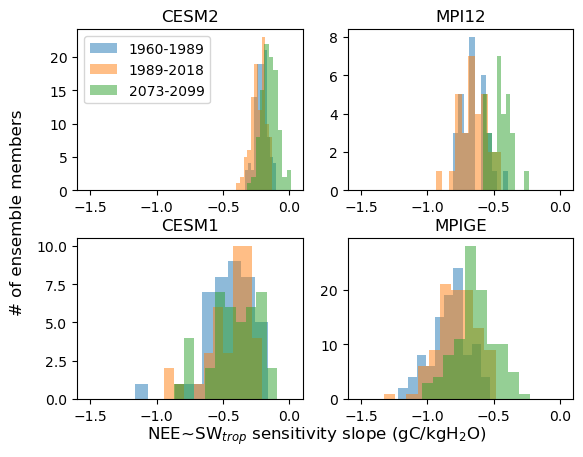

In [160]:
mdls=['CESM2','MPI12','CESM1','MPIGE']
y1s=[1960,1989,2073]
y2s=[1989,2018,2099]
xs={mdl:[mvals(mdl,y1,y2)[0] for y1,y2 in zip(y1s,y2s)] for mdl in mdls}

fig=plt.figure()
labs=[str(y1)+'-'+str(y2) for y1,y2 in zip(y1s,y2s)] 
for i,x in enumerate(xs):
    ax=fig.add_subplot(2,2,i+1)
    for j in range(3):
        ax.hist(xs[x][j],alpha=0.5,label=labs[j])
    ax.set_xlim([-1.6,0.1])
    ax.set_title(x)
    if i==0:
        plt.legend()
    
fig.subplots_adjust(hspace=0.3)
fig.supxlabel(r'NEE~SW$_{trop}$ sensitivity slope (gC/kgH$_2$O)')
fig.supylabel('# of ensemble members');
#plt.savefig('../figs/main/nee_swtrop_hists.png',dpi=300,bbox_inches='tight')

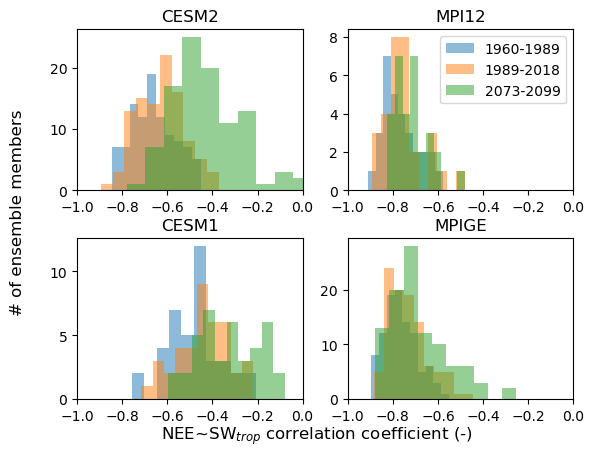

In [184]:
mdls=['CESM2','MPI12','CESM1','MPIGE']
y1s=[1960,1989,2073]
y2s=[1989,2018,2099]
xs={mdl:[mvals(mdl,y1,y2)[1] for y1,y2 in zip(y1s,y2s)] for mdl in mdls}

fig=plt.figure()
labs=[str(y1)+'-'+str(y2) for y1,y2 in zip(y1s,y2s)] 
for i,x in enumerate(xs):
    ax=fig.add_subplot(2,2,i+1)
    for j in range(3):
        ax.hist(xs[x][j],alpha=0.5,label=labs[j])
    ax.set_xlim([-1,0])
    ax.set_title(x)
    if i==1:
        plt.legend()
    
fig.subplots_adjust(hspace=0.3)
fig.supxlabel(r'NEE~SW$_{trop}$ correlation coefficient (-)')
fig.supylabel('# of ensemble members');
plt.savefig('../figs/supp/nee_swtrop_corrs.png',dpi=300,bbox_inches='tight')

0.7659718341869958

In [262]:

ix

<xarray.DataArray (ens: 100, year: 27)>
array([[False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [ True,  True, False, ..., False, False,  True],
       [False, False, False, ..., False,  True, False]])
Coordinates:
  * year     (year) int64 1989 1990 1994 1995 1996 ... 2014 2015 2016 2017 2018
  * ens      (ens) object 'LE2-1001.001.mip6.postp.nc' ... 'LE2-1301.020.smbb...

In [268]:
import glob

In [305]:
def amean(da):
    #annual mean
    m  = da['time.daysinmonth']
    xa = 1/m.groupby('time.year').sum()*(m*da).groupby('time.year').sum().compute()
    xa.name=da.name
    xa.attrs=da.attrs
    return xa

In [312]:
def get_eeyy(ee,yy):
    d='/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/TWS/'
    mem=ee.split('.')[0]+'.'+ee.split('.')[1]

    fs=np.array(sorted(glob.glob(d+'*'+mem+'*')))
    iys=np.array([f.split('.')[-2][:4] for f in fs]).astype(int)
    eys=np.array([f.split('.')[-2][-6:-2] for f in fs]).astype(int)

    files=np.unique([fs[(y>=iys)&(y<=eys)][0] for y in range(yy-15,yy+15)])

    return files



In [322]:
import dask

In [363]:
m='CESM2'
la=las[m]
ds=xr.open_dataset('/glade/scratch/djk2120/postp/twsnbp/cesm2.labeled.nc')
ix=get_ix(ds,y1s[1],y2s[1])
x=1e-9*la.sum()*detrend_dim(ds.SW_TROP.isel(year=ix),'year')
y=1e-9*la.sum()*24*60*60*365*detrend_dim(ds.NEE.isel(year=ix),'year')

ees=np.tile(ds.ens.values.reshape([-1,1]),[1,27])
yys=np.tile(resids.year,[100,1])
m,b,r,p,err=stats.linregress(x.values.ravel(),y.values.ravel())
resids=y-m*x-b

In [366]:
nn=np.quantile(resids*(resids.year!=2010),0.03)
ix=(resids<nn)&(resids.year!=2010)

xas=[]
i=0
for ee,yy in zip(ees[ix],yys[ix]):
    i+=1
    files=get_eeyy(ee,yy)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds=xr.open_mfdataset(files,combine='by_coords')
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        xa=detrend_dim(amean(ds.TWS.sel(time=slice(str(yy-13),str(yy+13)))),'year').sel(year=yy)
    xas.append(xa)
    if i%10==0:
        print(i)

10
20
30
40
50
60
70
80


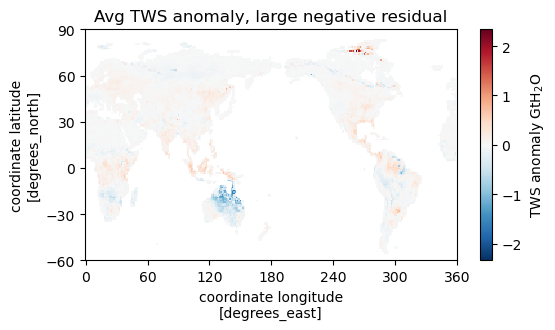

In [368]:
da=xr.concat(xas,dim='ensyear')
x=da.mean(dim='ensyear')
plt.figure(figsize=[6,3])
(1e-6*la*x).plot(cbar_kwargs={'label':'TWS anomaly GtH$_2$O'})
plt.ylim([-60,90])
plt.yticks(-60+30*np.arange(6));
plt.xticks(60*np.arange(7))
plt.title('Avg TWS anomaly, large negative residual');
plt.savefig('../figs/supp/tws_resid_neg.png',dpi=300,bbox_inches='tight')

In [369]:
nn=np.quantile(resids*(resids.year!=2010),0.97)
ix=(resids>nn)&(resids.year!=2010)

xas=[]
i=0
for ee,yy in zip(ees[ix],yys[ix]):
    i+=1
    files=get_eeyy(ee,yy)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds=xr.open_mfdataset(files,combine='by_coords')
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        xa=detrend_dim(amean(ds.TWS.sel(time=slice(str(yy-13),str(yy+13)))),'year').sel(year=yy)
    xas.append(xa)
    if i%10==0:
        print(i)

10
20
30
40
50
60
70
80


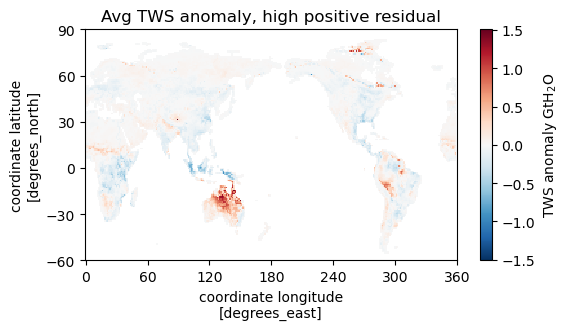

In [370]:
da=xr.concat(xas,dim='ensyear')
x=da.mean(dim='ensyear')
plt.figure(figsize=[6,3])
(1e-6*la*x).plot(cbar_kwargs={'label':'TWS anomaly GtH$_2$O'})
plt.ylim([-60,90])
plt.yticks(-60+30*np.arange(6));
plt.xticks(60*np.arange(7))
plt.title('Avg TWS anomaly, high positive residual');
plt.savefig('../figs/supp/tws_resid_pos.png',dpi=300,bbox_inches='tight')

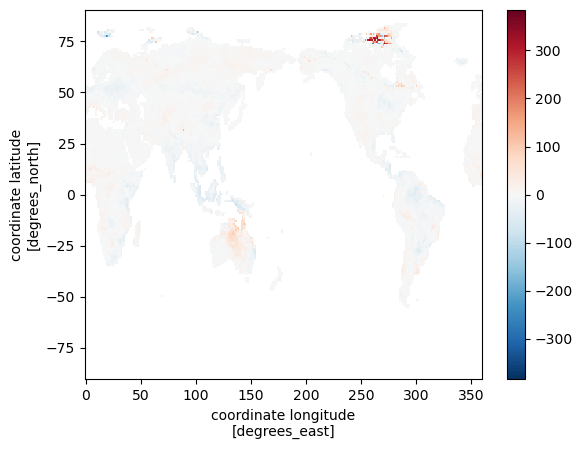

In [335]:
da.where(la>0).mean(dim='ensyear').plot()

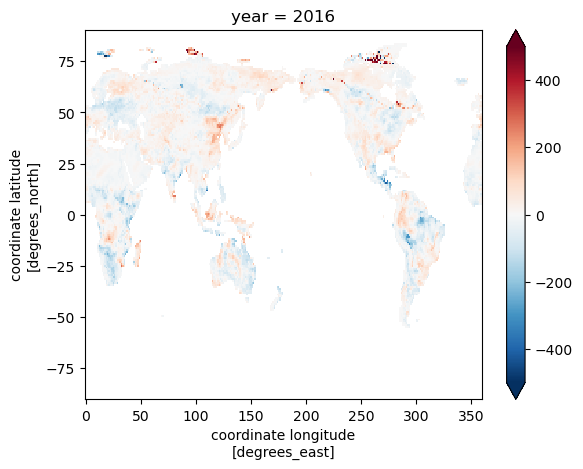

In [317]:
xa.where(la>0).sel(year=yy).plot(vmin=-500,vmax=500,cmap="RdBu_r")

In [227]:
fs=['/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/NBP/b.e21.BSSP370cmip6.f09_g17.LE2-1301.010.clm2.h0.NBP.209501-210012.nc',
'/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/NBP/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.clm2.h0.NBP.192001-192912.nc']

In [242]:
f=fs[1]
x=f.split('.')
fout='/glade/scratch/djk2120/postp/twsnbp/'+x[4]+'.'+x[5]+'.'+x[2][-4:]+'.postp.nc'
fout

'/glade/scratch/djk2120/postp/twsnbp/LE2-1301.011.smbb.postp.nc'

In [201]:
s=[stats.linregress(x.sel(year=yy),y.sel(year=yy))[0] for yy in x.year]
    

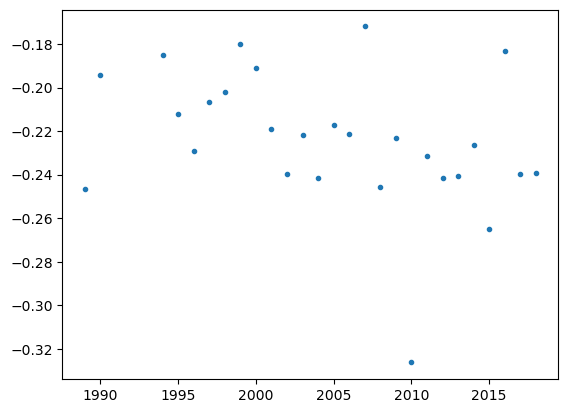

In [202]:
plt.plot(x.year,s,'.')

In [181]:
for m in mdls:
    ds=xr.open_dataset('/glade/u/home/djk2120/TWSnbp/postp/'+m.lower()+'.globann.nc')
    for i in range(3):
        ix=get_ix(ds,y1s[i],y2s[i])
        x=detrend_dim(ds.SW.isel(year=ix),'year').values.ravel()
        y=detrend_dim(ds.NEE.isel(year=ix),'year').values.ravel()
        r=np.round(np.corrcoef(x,y)[0,1],2)
        print(m,str(y1s[i])+'-'+str(y2s[i]),'R='+str(r))

CESM2 1960-1989 R=-0.57
CESM2 1989-2018 R=-0.54
CESM2 2073-2099 R=-0.43
MPI12 1960-1989 R=-0.74
MPI12 1989-2018 R=-0.72
MPI12 2073-2099 R=-0.7
CESM1 1960-1989 R=-0.46
CESM1 1989-2018 R=-0.46
CESM1 2073-2099 R=-0.48
MPIGE 1960-1989 R=-0.72
MPIGE 1989-2018 R=-0.69
MPIGE 2073-2099 R=-0.67


In [142]:
for x in xs:
    for i in range(2):
        for j in range(i+1,3):
            f,p=stats.ttest_ind(xs[x][i],xs[x][j])
            m1=np.round(np.mean(xs[x][i]),3)
            m2=np.round(np.mean(xs[x][j]),3)
            if p<0.05:

                if m1>m2:
                    c='>'
                else:
                    c='<'
                print(x,str(y1s[i])+'-'+str(y2s[i])+'('+str(m1)+')',c,str(y1s[j])+'-'+str(y2s[j])+'('+str(m2)+')')
            else:
                print(x,str(y1s[i])+'-'+str(y2s[i])+'('+str(m1)+')','=',str(y1s[j])+'-'+str(y2s[j])+'('+str(m2)+')')

CESM2 1960-1989(-0.21) > 1989-2018(-0.232)
CESM2 1960-1989(-0.21) < 2073-2099(-0.148)
CESM2 1989-2018(-0.232) < 2073-2099(-0.148)
MPI12 1960-1989(-0.651) = 1989-2018(-0.651)
MPI12 1960-1989(-0.651) < 2073-2099(-0.452)
MPI12 1989-2018(-0.651) < 2073-2099(-0.452)
CESM1 1960-1989(-0.461) = 1989-2018(-0.44)
CESM1 1960-1989(-0.461) = 2073-2099(-0.417)
CESM1 1989-2018(-0.44) = 2073-2099(-0.417)
MPIGE 1960-1989(-0.834) < 1989-2018(-0.777)
MPIGE 1960-1989(-0.834) < 2073-2099(-0.642)
MPIGE 1989-2018(-0.777) < 2073-2099(-0.642)


CESM2 1960-1989   -0.21 
CESM2 1989-2018  -0.232 *
CESM2 2073-2099  -0.148 **
MPI12 1960-1989  -0.651 
MPI12 1989-2018  -0.651 =
MPI12 2073-2099  -0.452 **
CESM1 1960-1989  -0.461 
CESM1 1989-2018   -0.44 =
CESM1 2073-2099  -0.417 ==
MPIGE 1960-1989  -0.834 
MPIGE 1989-2018  -0.777 *
MPIGE 2073-2099  -0.642 **


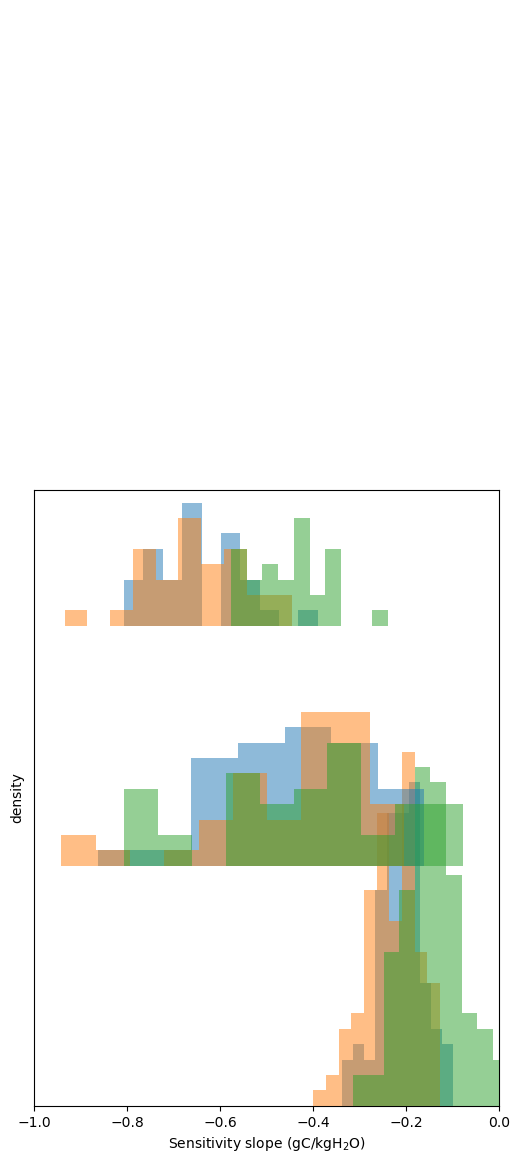

In [74]:
fig, ax1 = plt.subplots(ncols=1,figsize=[6,8])
ax1.set(xlim=(-1, 0), ylim=(0, 40))

ax1.set_xlabel('Sensitivity slope (gC/kgH$_2$O)')
ax1.set_ylabel('density')
ax1.set_yticks([])


yshift=0.3
for i,x in enumerate(xs):
    ax= fig.add_subplot(111, sharex=ax1, sharey=ax1, label="ax2")
    pos = ax.get_position()
    newpos = Bbox.from_bounds(pos.x0, pos.y0+i*yshift, pos.width, pos.height)
    ax.set_position(newpos)
    ax.axis('off')
    for j in range(3):
        ax.hist(xs[x][j],alpha=0.5)

In [ ]:

fig, axes = plt.subplots(ncols=2,figsize=[10,8])
ax1,ax2=axes
ax1.set(xlim=(0, 20), ylim=(0, 1e7))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(5*np.arange(5))
ax1.set_yticks([])
ax1.set_xlabel('TLAI (m2/m2)')
ax1.set_ylabel('relative land area')

ax1.plot([],[],'k:',label='LAI-obs')
ax1.legend()


ax2.set(xlim=(0, 5), ylim=(0, 1e7))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_yticks([])
ax2.set_xlabel('TLAI (m2/m2)')


for s,pps,bmax,axx in zip([121,122],[pftranks[:8],pftranks[8:]],[20,5],[ax1,ax2]):
    bins = np.linspace(0, bmax, 40)
    xshift=0; yshift=0.08
    for i,pft in enumerate(pps):
        ax= fig.add_subplot(s, sharex=axx, sharey=axx, label="ax2")
        wts=np.tile(lapft.isel(pft=pft)/501,501)
        ax.hist(da.isel(pft=pft),bins,weights=wts,color="C"+str(i),alpha=0.7)
        if pft<15:
            ll=laisp.isel(pft=pft)
            ax.plot([ll,ll],[0,0.08e7],'k:')
        ax.patch.set_visible(False)
        pos = ax.get_position()
        newpos = Bbox.from_bounds(pos.x0+i*xshift, pos.y0+i*yshift, pos.width, pos.height)
        ax.set_position(newpos)
        ax.axis('off')
        ax.text(0.95*bmax,2e5,pfts[pft.values+1],ha='right')

plt.savefig('../figs/pft/lhc_hists.png',dpi=500,bbox_inches="tight")


In [31]:
stats.ttest_ind(m0,m1)

Ttest_indResult(statistic=0.003403320381354426, pvalue=0.9972962273104877)

In [32]:
stats.ttest_ind(m2,m1)

Ttest_indResult(statistic=8.402811019224675, pvalue=1.298721886824665e-11)

In [33]:
stats.ttest_ind(m2,m0)

Ttest_indResult(statistic=8.74348761167842, pvalue=3.5228637739130386e-12)

(array([5., 3., 4., 3., 7., 2., 5., 0., 0., 1.]),
 array([-0.5769775 , -0.54324925, -0.509521  , -0.47579275, -0.44206451,
        -0.40833626, -0.37460801, -0.34087976, -0.30715152, -0.27342327,
        -0.23969502]),
 <BarContainer object of 10 artists>)

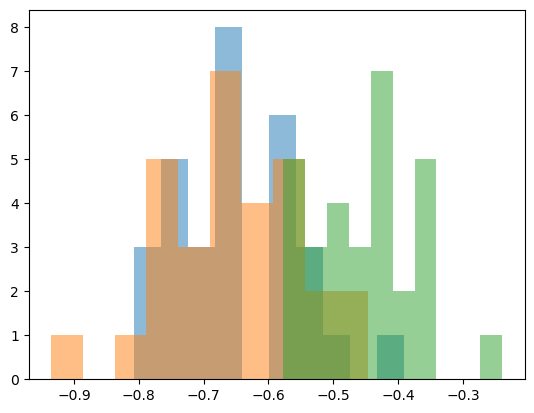

In [34]:
plt.hist(m0,alpha=0.5)
plt.hist(m1,alpha=0.5)
plt.hist(m2,alpha=0.5)


In [4]:
def mvals(mdl,yr0,yr1):
    avoids=[1962,1963,1982,1991,1992,1993]
    
    la=las[mdl]
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    
    ix=(ds['year']>=yr0)&(ds['year']<=yr1)
    for yr in avoids:
        ix=(ix)&(ds['year']!=yr)
    print('nyears=',ix.sum().values)
    x=detrend_dim(1e-9*la.sum()*ds.SW_TROP.isel(year=ix),'year')
    y=detrend_dim(1e-9*24*60*60*365*la.sum()*ds.NBP.isel(year=ix),'year')
    m=[stats.linregress(x.sel(ens=ee),y.sel(ens=ee))[0] for ee in ds.ens]
    r=[stats.linregress(x.sel(ens=ee),y.sel(ens=ee))[2] for ee in ds.ens]
    
    return m,r

In [18]:
np.mean(r0)

0.6596947198959034

In [19]:
np.mean(r1)

0.6472916465987573

nyears= 27
nyears= 27
0.2556470913064978 0.2456748520182092


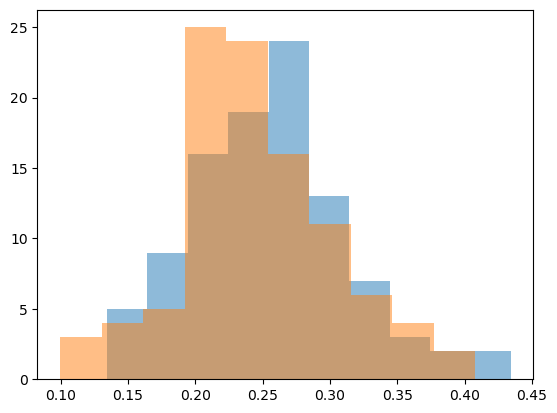

In [16]:
m0,r0=mvals('CESM2',1960,1989)
m1,r1=mvals('CESM2',1989,2018)
#m1,r1=mvals('CESM2',2060,2086)

print(np.mean(m0),np.mean(m1))

plt.hist(m0,alpha=0.5)
plt.hist(m1,alpha=0.5);

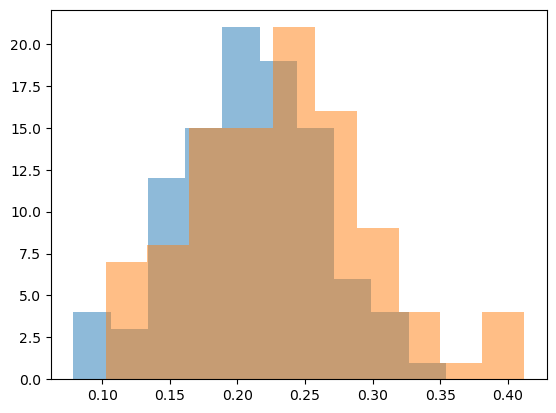

In [117]:
avoids=[1962,1963,1982,1991,1992,1993]
ix=(ds['year']>=1989)&(ds['year']<=2018)
for yr in avoids:
    ix=(ix)&(ds['year']!=yr)
print(ix.sum())
x=detrend_dim(1e-9*la.sum()*ds.SW_TROP.isel(year=ix),'year')
y=detrend_dim(1e-9*24*60*60*365*la.sum()*ds.NBP.isel(year=ix),'year')
m1=[stats.linregress(x.sel(ens=ee),y.sel(ens=ee))[0] for ee in ds.ens]

<xarray.DataArray 'year' ()>
array(27)


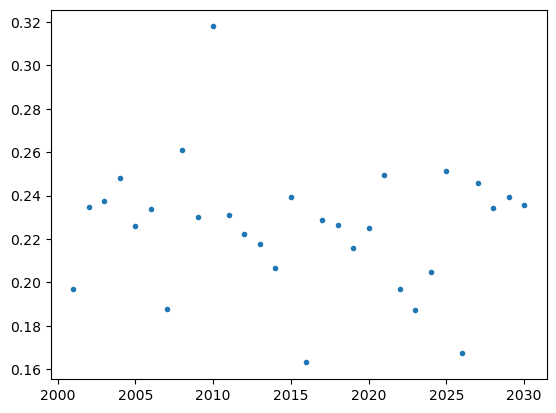

In [115]:
plt.plot(x.year,myy,'.')

In [100]:
stats.ttest_ind(m0,m1)

Ttest_indResult(statistic=-2.860242413447753, pvalue=0.004687196542602285)

In [101]:
np.mean(m1)


0.2327497567703162

In [102]:
np.mean(m0)

0.20876742822678274

(array([ 7.,  8., 15., 15., 21., 16.,  9.,  4.,  1.,  4.]),
 array([0.10252442, 0.13347604, 0.16442765, 0.19537927, 0.22633088,
        0.2572825 , 0.28823412, 0.31918573, 0.35013735, 0.38108897,
        0.41204058]),
 <BarContainer object of 10 artists>)

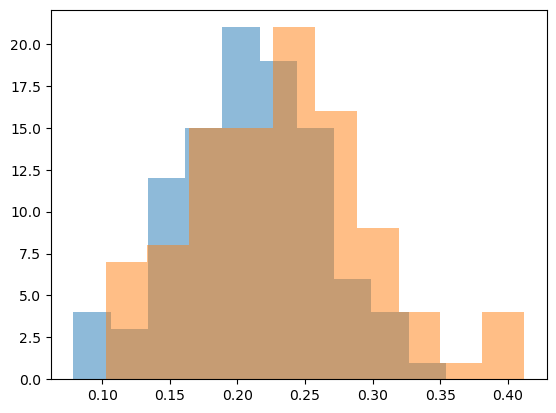

In [97]:
plt.hist(m0,alpha=0.5)
plt.hist(m1,alpha=0.5)

In [39]:
ix=(ds['year']>1960)&(ds['year']<1991)
x=detrend_dim(1e-9*la.sum()*ds.SW_TROP.isel(year=ix),'year')
t=detrend_dim(ds.TSA_TROP.isel(year=ix),'year')
y=detrend_dim(1e-9*24*60*60*365*la.sum()*ds.NBP.isel(year=ix),'year')

In [64]:
msw=
mtsa=[stats.linregress(t.sel(ens=ee),y.sel(ens=ee))[0] for ee in ds.ens]

In [62]:
ms=[]
mt=[]
for ee in ds.ens:
    X=np.vstack([x.sel(ens=ee).values,t.sel(ens=ee).values]).T
    lm=sm.OLS(y.sel(ens=ee).values,X).fit()
    ms.append(lm.params[0])
    mt.append(lm.params[1])

(array([11., 13.,  7., 13., 17., 15.,  5., 13.,  3.,  3.]),
 array([-0.02588157,  0.00824351,  0.0423686 ,  0.07649369,  0.11061877,
         0.14474386,  0.17886894,  0.21299403,  0.24711911,  0.2812442 ,
         0.31536928]),
 <BarContainer object of 10 artists>)

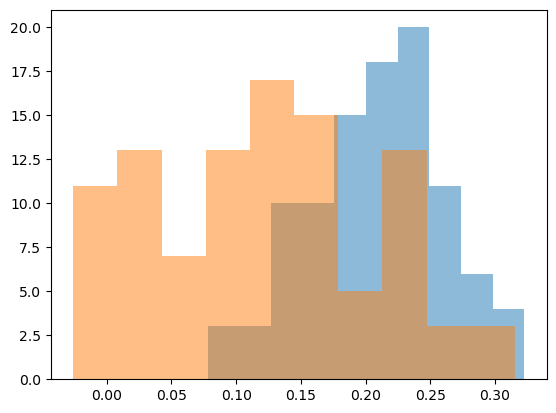

In [63]:
plt.hist(msw,alpha=0.5)
plt.hist(ms,alpha=0.5)

(array([ 2., 10., 13., 11., 19., 10., 15.,  6.,  7.,  7.]),
 array([-1.56613981, -1.39021075, -1.21428169, -1.03835264, -0.86242358,
        -0.68649452, -0.51056546, -0.3346364 , -0.15870734,  0.01722172,
         0.19315077]),
 <BarContainer object of 10 artists>)

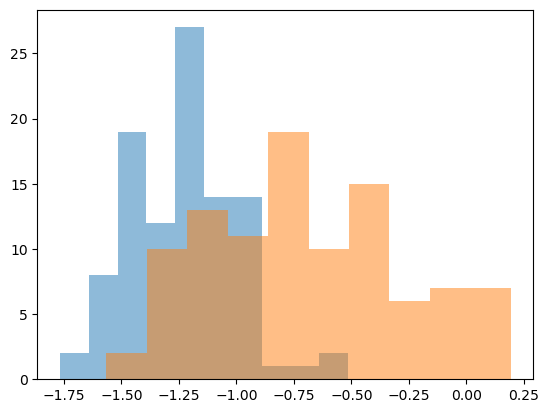

In [65]:
plt.hist(mtsa,alpha=0.5)
plt.hist(mt,alpha=0.5)

In [37]:
import statsmodels.api as sm

(array([ 3.,  3., 10., 10., 15., 18., 20., 11.,  6.,  4.]),
 array([0.0781254 , 0.10256957, 0.12701374, 0.1514579 , 0.17590207,
        0.20034623, 0.2247904 , 0.24923457, 0.27367873, 0.2981229 ,
        0.32256706]),
 <BarContainer object of 10 artists>)

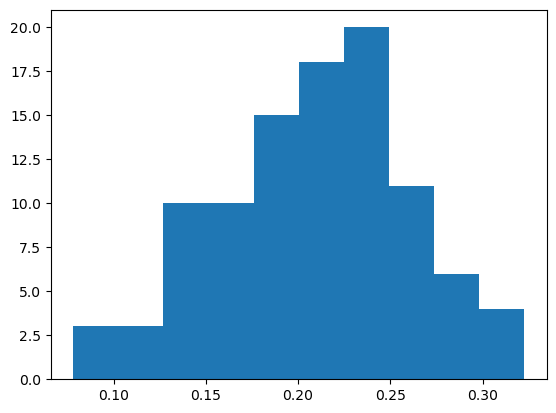

In [36]:
plt.hist(msw)

In [30]:
x=detrend_dim(1e-9*la.sum()*ds.SW.isel(year=ix),'year')
y=detrend_dim(1e-9*24*60*60*365*la.sum()*ds.NBP.isel(year=ix),'year')
stats.linregress(x.values.ravel(),y.values.ravel())

LinregressResult(slope=0.3925908527423625, intercept=-2.626143356626304e-14, rvalue=0.5388302166745185, pvalue=1.438651113330257e-225, stderr=0.011209808529849532, intercept_stderr=0.008369205370338135)

LinregressResult(slope=0.3925908527423625, intercept=-2.626143356626304e-14, rvalue=0.5388302166745185, pvalue=1.438651113330257e-225, stderr=0.011209808529849532, intercept_stderr=0.008369205370338135)

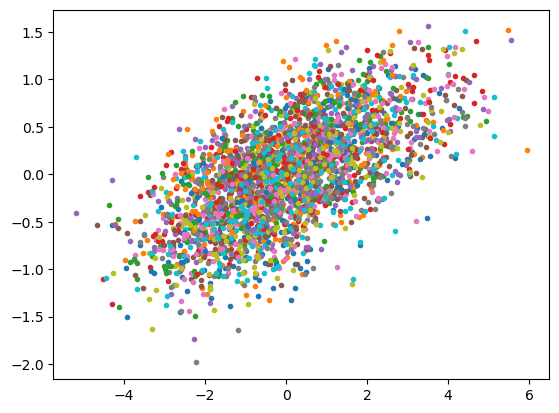

In [18]:
plt.plot(x,y,'.');

<xarray.DataArray (ens: 100, year: 181)>
array([[ 0.37274952, -0.2181102 , -1.48748812, ...,  3.45673126,
         2.40748098,  2.25149448],
       [-0.69016691, -1.89178149,  0.06356771, ...,  2.33878338,
         1.76280988,  2.81258271],
       [ 0.25443386, -1.97755914,  0.51878704, ...,  2.06550742,
         3.26269107,  2.62860105],
       ...,
       [-0.57477435, -0.19942796,  0.10146705, ...,  2.30220439,
         2.73383596,  1.9075235 ],
       [ 0.49636301, -0.80450846, -0.73885287, ...,  2.90384378,
         1.41061514,  2.33237707],
       [-0.97670902, -0.31943337, -0.45825833, ...,  2.6701363 ,
         2.59056626,  2.81959827]])
Coordinates:
  * year     (year) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: ens

In [142]:

mvals={}
rvals={}
pvals={}
rens={}
for mdl in mdls:
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    
    yy=slice(1960,1989)
    ya=1e-9*24*60*60*365*la.sum()*detrend_dim(ds.NBP.sel(year=yy),'year')
    xa=1e-9*la.sum()*detrend_dim(ds.SW.sel(year=yy),'year')
    
    rens[mdl]=np.round(np.corrcoef(xa.values.ravel(),ya.values.ravel())[0,1],2)
    mvals[mdl]=[stats.linregress(xa.sel(ens=ee),ya.sel(ens=ee))[0] for ee in ds.ens]
    rvals[mdl]=[stats.linregress(xa.sel(ens=ee),ya.sel(ens=ee))[2] for ee in ds.ens]
    pvals[mdl]=[stats.linregress(xa.sel(ens=ee),ya.sel(ens=ee))[3] for ee in ds.ens]
    

In [134]:
for mdl in mdls:
    print(mdl,(np.array(pvals[mdl])>0.05).sum()/len(pvals[mdl]))

CESM1 0.225
CESM2 0.11
MPIGE 0.02
MPI12 0.0


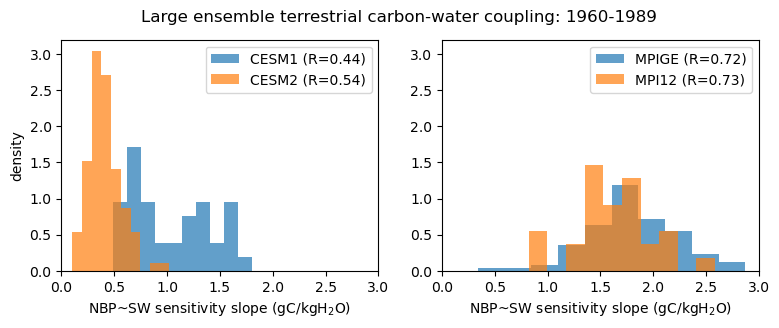

In [141]:
plt.figure(figsize=[9,3])
for i,mdl in enumerate(mvals):
    j=1+int(i/2)
    plt.subplot(1,2,j)
    plt.hist(mvals[mdl],density=True,label=mdl+' (R='+str(rens[mdl])+')',alpha=0.7)
    plt.xlim([0,3])
    plt.ylim([0,3.2])
    plt.legend()
    if j==1:
        plt.ylabel('density')
    plt.xlabel(r'NBP~SW sensitivity slope (gC/kgH$_2$O)')
    
plt.suptitle('Large ensemble terrestrial carbon-water coupling: 1960-1989');
plt.savefig('../figs/main/glob_nbpsw_sens_30yr.png',dpi=300,bbox_inches='tight')

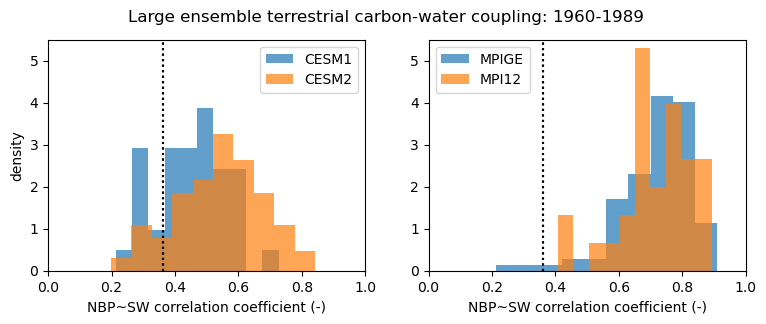

In [124]:
plt.figure(figsize=[9,3])
for i,mdl in enumerate(mvals):
    j=1+int(i/2)
    plt.subplot(1,2,j)
    plt.hist(rvals[mdl],density=True,label=mdl,alpha=0.7)
    plt.xlim([0,1])
    plt.ylim([0,5.5])
    plt.plot([0.361,0.361],[0,6],'k:')
    plt.legend()
    if j==1:
        plt.ylabel('density')
    plt.xlabel(r'NBP~SW correlation coefficient (-)')
    
plt.suptitle('Large ensemble terrestrial carbon-water coupling: 1960-1989');
plt.savefig('../figs/supp/glob_nbpsw_corr_30yr.png',dpi=300,bbox_inches='tight')

In [143]:

mvals={}
rvals={}
pvals={}
rens={}
for mdl in mdls:
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    
    y1='1976'
    y2='1990'
    yy=slice(y1,y2)
    ya=1e-9*24*60*60*365*la.sum()*detrend_dim(ds.NBP.sel(year=yy),'year')
    xa=1e-9*la.sum()*detrend_dim(ds.SW.sel(year=yy),'year')
    
    rens[mdl]=np.round(np.corrcoef(xa.values.ravel(),ya.values.ravel())[0,1],2)
    mvals[mdl]=[stats.linregress(xa.sel(ens=ee),ya.sel(ens=ee))[0] for ee in ds.ens]
    rvals[mdl]=[stats.linregress(xa.sel(ens=ee),ya.sel(ens=ee))[2] for ee in ds.ens]
    pvals[mdl]=[stats.linregress(xa.sel(ens=ee),ya.sel(ens=ee))[3] for ee in ds.ens]
    

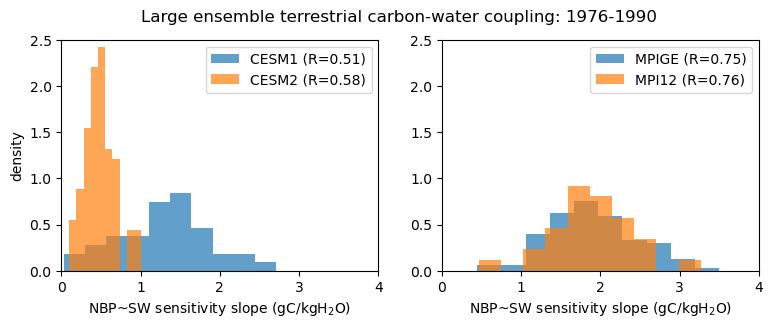

In [150]:
plt.figure(figsize=[9,3])
for i,mdl in enumerate(mvals):
    j=1+int(i/2)
    plt.subplot(1,2,j)
    plt.hist(mvals[mdl],density=True,label=mdl+' (R='+str(rens[mdl])+')',alpha=0.7)
    plt.xlim([0,4])
    plt.ylim([0,2.5])
    plt.legend()
    if j==1:
        plt.ylabel('density')
    plt.xlabel(r'NBP~SW sensitivity slope (gC/kgH$_2$O)')
    
plt.suptitle('Large ensemble terrestrial carbon-water coupling: '+y1+'-'+y2);
plt.savefig('../figs/supp/glob_nbpsw_sens_15yr.png',dpi=300,bbox_inches='tight')

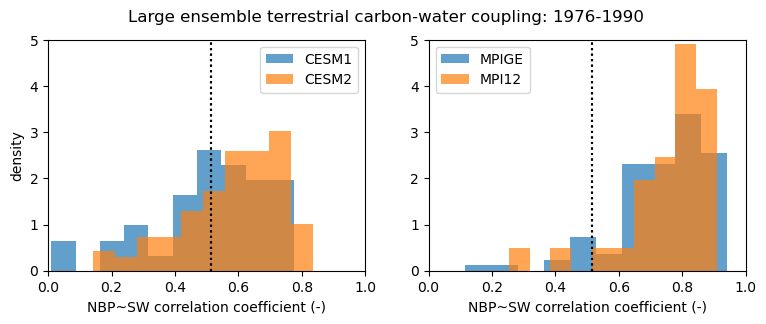

In [153]:
plt.figure(figsize=[9,3])
for i,mdl in enumerate(mvals):
    j=1+int(i/2)
    plt.subplot(1,2,j)
    plt.hist(rvals[mdl],density=True,label=mdl,alpha=0.7)
    plt.xlim([0,1])
    plt.ylim([0,5])
    plt.plot([0.514,0.514],[0,6],'k:')
    plt.legend()
    if j==1:
        plt.ylabel('density')
    plt.xlabel(r'NBP~SW correlation coefficient (-)')
    
plt.suptitle('Large ensemble terrestrial carbon-water coupling: '+y1+'-'+y2);
plt.savefig('../figs/supp/glob_nbpsw_corr_15yr.png',dpi=300,bbox_inches='tight')

In [154]:
for mdl in mdls:
    print(mdl,(np.array(pvals[mdl])>0.05).sum()/len(pvals[mdl]))

CESM1 0.45
CESM2 0.31
MPIGE 0.08
MPI12 0.06451612903225806


In [120]:
rs=[]
ps=[]
for i in range(1000):
    x=np.random.rand(30)
    y=x+1.5*np.random.rand(30)
    m,b,r,p,err=stats.linregress(x,y)
    rs.append(r)
    ps.append(p)
    
r=np.array(rs)
p=np.array(ps)
ix=np.argmin(abs(p-0.05))
p[ix],r[ix]

(0.050037964104742656, 0.3609511935310988)

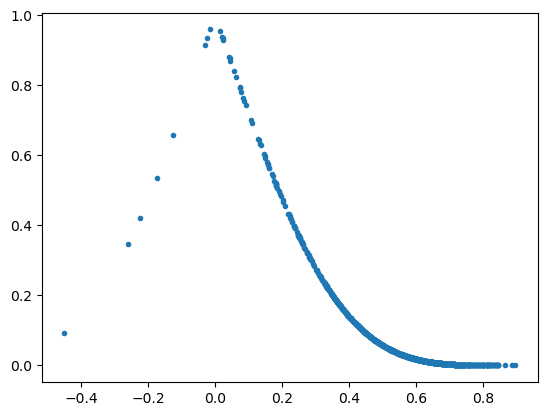

In [112]:
plt.plot(rs,ps,'.')

In [5]:
mvals={'CESM1':[],'CESM2':[],'MPIGE':[],'MPI12':[]}
rvals={'CESM1':[],'CESM2':[],'MPIGE':[],'MPI12':[]}
for mdl in ['CESM1','CESM2','MPIGE','MPI12']:
    f='/glade/u/home/djk2120/TWSnbp/postp/'+mdl.lower()+'.globann.nc'
    ds=xr.open_dataset(f)
    la=las[mdl]
    cf=1e-9*24*60*60*365*la.sum()
    yy=slice(1976,1990)
    xa=1e-9*la.sum()*detrend_dim(ds.SW.sel(year=yy),'year')
    ya=detrend_dim(cf*ds.NBP.sel(year=yy),'year')
    for ee in ds.ens:
        m,b,r,p,err=stats.linregress(xa.sel(ens=ee),ya.sel(ens=ee))
        mvals[mdl].append(m)
        rvals[mdl].append(r)
 

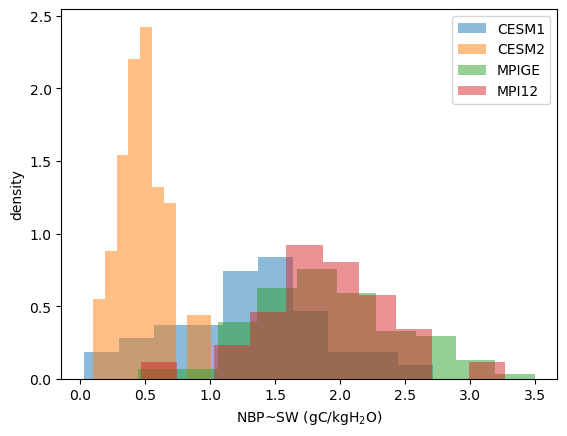

In [34]:
for m in mvals:
    plt.hist(mvals[m],density=True,label=m,alpha=0.5)
plt.legend()
plt.ylabel('density')
plt.xlabel(r'NBP~SW (gC/kgH$_2$O)');
plt.savefig('../figs/main/hists.png',dpi=300,bbox_inches='tight')

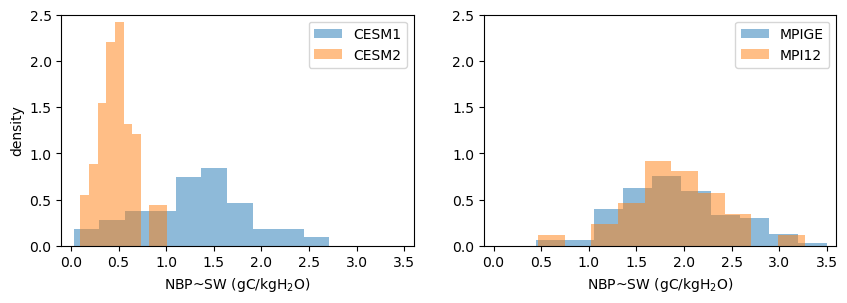

In [6]:
plt.figure(figsize=[10,3])
plt.subplot(121)
for m in ['CESM1','CESM2']:
    plt.hist(mvals[m],density=True,label=m,alpha=0.5)
plt.legend();
plt.xlim([-0.1,3.6])
plt.ylim([0,2.5])
plt.ylabel('density')
plt.xlabel(r'NBP~SW (gC/kgH$_2$O)')

plt.subplot(122)
for m in ['MPIGE','MPI12']:
    plt.hist(mvals[m],density=True,label=m,alpha=0.5)
plt.xlim([-0.1,3.6])
plt.ylim([0,2.5])
plt.xlabel(r'NBP~SW (gC/kgH$_2$O)')
plt.legend();
plt.savefig('../figs/main/hists_split.png',dpi=300,bbox_inches='tight')

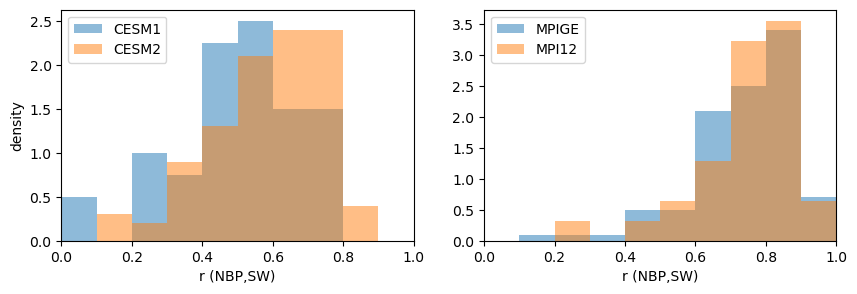

In [20]:
plt.figure(figsize=[10,3])
plt.subplot(121)
for m in ['CESM1','CESM2']:
    plt.hist(rvals[m],bins=np.arange(11)/10,density=True,label=m,alpha=0.5)
plt.legend();
plt.xlim([0,1])
#plt.ylim([0,2.5])
plt.ylabel('density')
plt.xlabel(r'r (NBP,SW)')

plt.subplot(122)
for m in ['MPIGE','MPI12']:
    plt.hist(rvals[m],bins=np.arange(11)/10,density=True,label=m,alpha=0.5)
#plt.xlim([-0.1,3.6])
plt.xlim([0,1])
plt.xlabel(r'r (NBP,SW)')
plt.legend();
plt.savefig('../figs/main/rhists_split.png',dpi=300,bbox_inches='tight')

In [3]:
files=lens_files('CESM','TWS')

In [5]:
ds=xr.open_dataset(files[0][0])

In [7]:
ds.landfrac

<xarray.DataArray 'landfrac' (lat: 192, lon: 288)>
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    long_name:  land fraction

In [4]:
def get_ds(files,dims,dvs=[],appends={},singles=[],yy=None):
    if dvs:
        def preprocess(ds):
            return ds[dvs]
    else:
        def preprocess(ds):
            return ds
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=dims,
                   parallel=True,
                   preprocess=preprocess)

    f=np.array(files).ravel()[0]
    htape=f.split('clm2')[1][1:3]

    #add extra variables
    tmp = xr.open_dataset(f)
    for v in tmp.data_vars:
        if 'time' not in tmp[v].dims: 
            if v not in ds:
                ds[v]=tmp[v]
    
    #fix up time dimension, swap pft
    if (htape=='h0')|(htape=='h1'):
        yr0=str(ds['time.year'][0].values)
        nt=len(ds.time)
        ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    if (htape=='h1'):
        ds['pft']=ds['pfts1d_itype_veg']
        
    
    for append in appends:
        ds[append]=appends[append]
        
    if yy:
        ds=ds.sel(time=slice(str(yy[0]),str(yy[1])))
             
    return ds

In [2]:
def lens_files(model,dv,yy=(1960,2050)):
    
    y1=yy[0]
    y2=yy[1]
    
    if model=='CESM1':
        d='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/lnd/proc/tseries/monthly/'+dv+'/'
        match=['C5CNBDRD','h0']
        nixes=['OIC','106','107']
    else:
        d='/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/'+dv+'/'
        match=['f09_g17','h0']
        nixes=[]
        
    #find all files
    fs=sorted(glob.glob(d+'*'))

    #nix some
    files=[]
    for f in fs:
        add=True
        for m in match:
            if m not in f:
                add=False
        for n in nixes:
            if n in f:
                add=False
        if add:
            files.append(f)
    files=np.array(files)

    #filter to match years
    yr1s = np.array([int(f.split('.')[-2].split('-')[0][:4]) for f in files])
    yr2s = np.array([int(f.split('.')[-2].split('-')[1][:4]) for f in files])
    ix=((yr1s<=y2)&(yr1s>=y1))|((yr2s<=y2)&(yr2s>=y1))
    files=files[ix]

    #sort by member
    mems = np.array([f.split('f09')[1].split('clm2')[0] for f in files])
    out=[list(files[mems==mem]) for mem in np.unique(mems)]
    
    return out

In [14]:
from scipy import stats
from utils import *

In [6]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension (h/t rabernat)
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [15]:
dsets={exp:xr.open_dataset('../data/'+exp+'_glob_mean.nc.nc') for exp in ['CESM1','CESM2']}

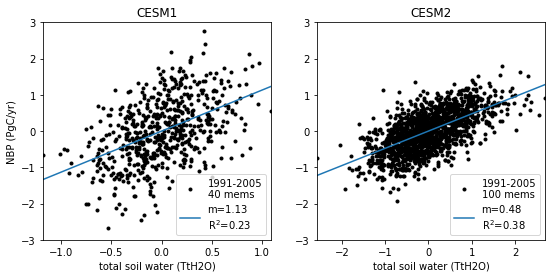

In [7]:
yy=slice('1991','2005')

plt.figure(figsize=[9,4])
for i,exp in enumerate(dsets):
    ds=dsets[exp]
    nens=len(ds.ens)
    x=detrend_dim(ds.SW.sel(year=yy),'year').values.ravel()
    y=detrend_dim(ds.NBP.sel(year=yy),'year').values.ravel()
    
    xv=np.array([x.min(),x.max()])
    lm=sm.OLS(y,sm.add_constant(x)).fit()
    m=str(np.round(lm.params[1],2))
    r2=str(np.round(lm.rsquared,2))
    plt.subplot(1,2,i+1)
    plt.plot(x,y,'k.',
             label='1991-2005\n'+str(nens)+' mems');
    plt.plot(xv,lm.params[0]+xv*lm.params[1],label='m='+m+'\n'+r'R$^2$='+r2)
    plt.ylim([-3,3])
    plt.title(exp)
    plt.xlabel('total soil water (TtH2O)')
    plt.legend(loc=4)
    plt.xlim(xv);
    
plt.subplot(121)
plt.ylabel('NBP (PgC/yr)');

In [8]:
ds=dsets['CESM2']
dvs=['GPP','AR','HR','COL_FIRE_CLOSS']
rs={exp+' (R~SW)':[np.round(np.corrcoef(
            detrend_dim(dsets[exp].SW.sel(year=yy),'year').values.ravel(),
            detrend_dim(dsets[exp][v].sel(year=yy),'year').values.ravel())[0,1],2)
    for v in dvs] for exp in dsets}
pd.DataFrame(rs,index=dvs)

,CESM1 (R~SW),CESM2 (R~SW)
GPP,0.54,0.63
AR,0.34,0.43
HR,-0.02,0.40
COL_FIRE_CLOSS,-0.67,-0.27


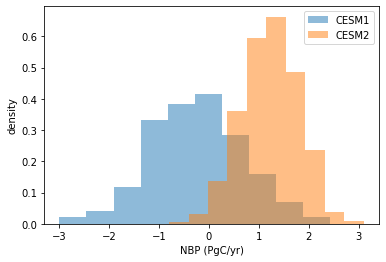

In [9]:
for exp in dsets:
    plt.hist(dsets[exp]['NBP'].sel(year=yy).values.ravel(),
             alpha=0.5,label=exp,density=True)
plt.legend()
plt.xlabel('NBP (PgC/yr)')
plt.ylabel('density');

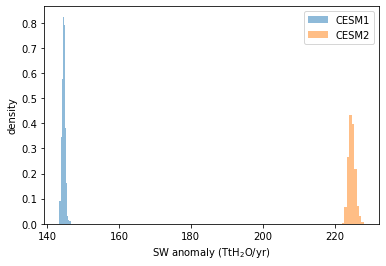

In [314]:
for exp in dsets:
    x=dsets[exp]['SW'].sel(year=yy).values.ravel()
    plt.hist(x,
             alpha=0.5,label=exp,density=True)
plt.legend()
plt.xlabel(r'SW anomaly (TtH$_2$O/yr)')
plt.ylabel('density');

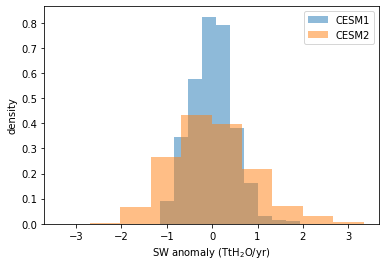

In [315]:
for exp in dsets:
    x=dsets[exp]['SW'].sel(year=yy).values.ravel()
    plt.hist(x-x.mean(),
             alpha=0.5,label=exp,density=True)
plt.legend()
plt.xlabel(r'SW anomaly (TtH$_2$O/yr)')
plt.ylabel('density');

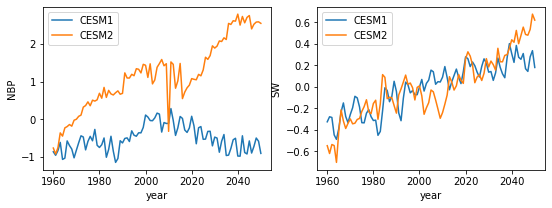

In [11]:
plt.figure(figsize=[9,3])
for i,v in enumerate(['NBP','SW']):
    plt.subplot(1,2,i+1)
    for exp in dsets:
        x=dsets[exp][v]
        if v=='SW':
            x=x-x.mean()
        plt.plot(ds.year,
                 x.mean(dim='ens'),
                 label=exp);
    plt.legend()
    plt.xlabel('year')
    plt.ylabel(v)

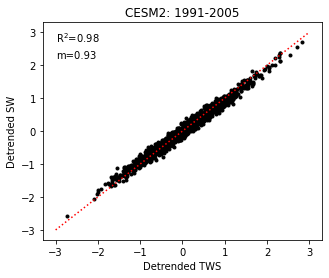

In [12]:
ds=dsets['CESM2']
tws=detrend_dim(ds.TWS.sel(year=yy),'year').values.ravel()
sw=detrend_dim(ds.SW.sel(year=yy),'year').values.ravel()
plt.figure(figsize=[5,4])
plt.plot(tws,sw,'k.');
plt.plot([-3,3],[-3,3],'r:')
plt.xlabel('Detrended TWS')
plt.ylabel('Detrended SW')

x=sm.add_constant(tws)
lm=sm.OLS(sw,x).fit()
r2=str(np.round(lm.rsquared,2))
m=str(np.round(lm.params[1],2))
plt.text(-3,2.7,r'R$^2$='+r2)
plt.text(-3,2.2,r'm='+m);
plt.title('CESM2: 1991-2005');

In [21]:
mvals={'CESM1':{},'CESM2':{}}
for exp in dsets:
    ds=dsets[exp]
    x=detrend_dim(ds.SW.sel(year=yy),'year').values
    for v in ['NBP','NPP','GPP','AR','HR','COL_FIRE_CLOSS']:
        y=detrend_dim(ds[v].sel(year=yy),'year').values
        mvals[exp][v]=[]
        for i in ds.ens.values:
            m, b, r, p, std_err = stats.linregress(x[:,i],y[:,i])
            mvals[exp][v].append(m)

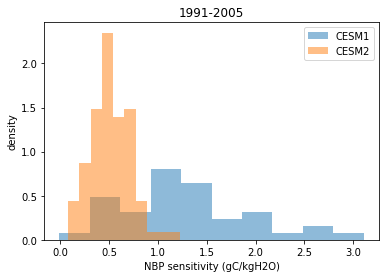

In [22]:
for exp in dsets:
    plt.hist(mvals[exp]['NBP'],density=True,alpha=0.5,label=exp)
plt.xlabel(r'NBP sensitivity (gC/kgH2O)')
plt.ylabel('density')
plt.legend()
plt.title('1991-2005');

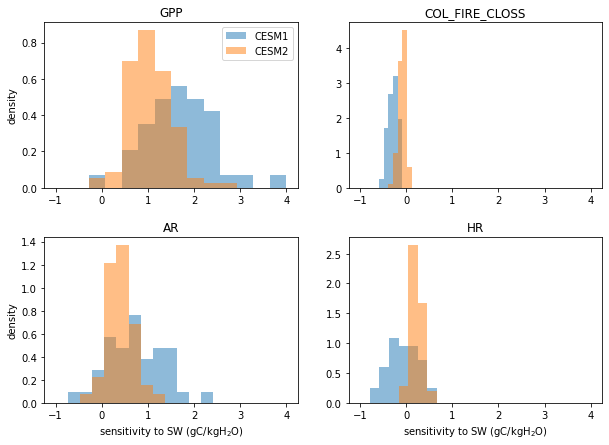

In [40]:
plt.figure(figsize=[10,7])
nbins=[15,50,20,25]
for i,v in enumerate(['GPP','COL_FIRE_CLOSS','AR','HR']):
    plt.subplot(2,2,i+1)
    for exp in dsets:
        plt.hist(mvals[exp][v],np.linspace(-1,4,nbins[i]),density=True,alpha=0.5,label=exp)
    if i==0:
        plt.legend()
    plt.title(v)
    if i>1:
        plt.xlabel(r'sensitivity to SW (gC/kgH$_2$O)')
    if i%2==0:
        plt.ylabel('density')
plt.subplots_adjust(hspace=0.3)

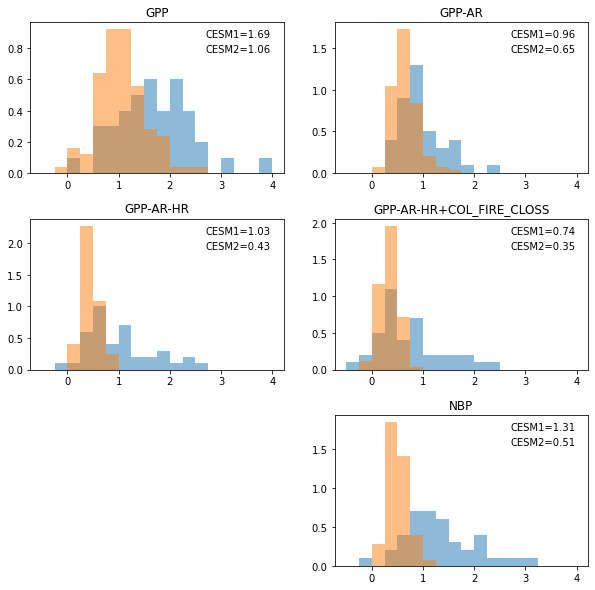

In [78]:
vlist=['GPP','AR','HR','COL_FIRE_CLOSS']
sgn=[1,-1,-1,1]
pm={1:'+',-1:'-'}
plt.figure(figsize=[10,10])
for i in range(4):
    plt.subplot(3,2,i+1)
    mavgs=[]
    for exp in dsets:
        ds=dsets[exp]
        x=detrend_dim(ds.SW.sel(year=yy),'year').values
        for j in range(i+1):
            if j==0:
                y0=ds[vlist[0]].sel(year=yy)
                s=vlist[0]
            else:
                y0=y0+sgn[j]*ds[vlist[j]].sel(year=yy)
                s=s+pm[sgn[j]]+vlist[j]
        y=detrend_dim(y0,'year').values
        ms=[]
        for k in ds.ens.values:
            m, b, r, p, std_err = stats.linregress(x[:,k],y[:,k])
            ms.append(m)
        plt.hist(ms,np.linspace(-0.5,4,19),density=True,alpha=0.5,label=exp)
        mavgs.append(str(np.round(np.mean(ms),2)))
    for ee,exp in enumerate(dsets):    
        ylims=plt.gca().get_ylim()
        plt.text(2.7,ylims[1]*(0.9-ee*0.1),exp+'='+mavgs[ee])
    plt.title(s)
plt.subplot(3,2,6)
mavgs=[]
for exp in dsets:
    mavgs.append(str(np.round(np.mean(mvals[exp]['NBP']),2)))
    plt.hist(mvals[exp]['NBP'],np.linspace(-0.5,4,19),density=True,alpha=0.5,label=exp)
for ee,exp in enumerate(dsets):    
    ylims=plt.gca().get_ylim()
    plt.text(2.7,ylims[1]*(0.9-ee*0.1),exp+'='+mavgs[ee])
plt.title('NBP')
plt.subplots_adjust(hspace=0.3)

### slope map

In [81]:
ds=xr.open_dataset('../data/slope_maps.nc')
da=(ds.pvalue<0.05)*ds.slope

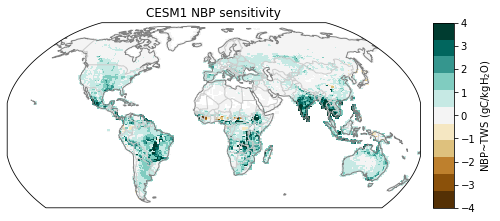

In [124]:
nicemap(da.sel(model='CESM1'),'CESM1 NBP sensitivity',r'NBP~TWS (gC/kgH$_2$O)',vmax=4)

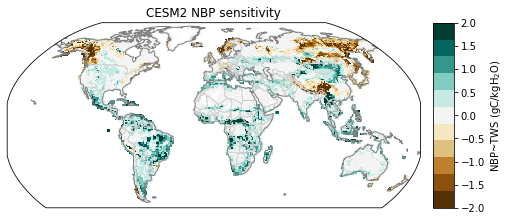

In [101]:
nicemap(da.sel(model='CESM2'),'CESM2 NBP sensitivity',r'NBP~TWS (gC/kgH$_2$O)',vmax=2)

### examine TWS anomalies

In [273]:
def get_one(v,ee,yr,cf=None):
    files=lens_files('CESM2',v,yy=(1991,2005))

    def preprocess(ds):
        return ds[[v]]

    ds=xr.open_mfdataset(files[ee],combine='nested',concat_dim='time',preprocess=preprocess)

    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    
    x=amean(ds[v].sel(time=slice('1991','2005')),cf=cf)
    
    
    return detrend_dim(x,'year').sel(year=yr)

In [274]:
dsets={exp:xr.open_dataset('../data/'+exp+'_glob_mean.nc.nc') for exp in ['CESM1','CESM2']}

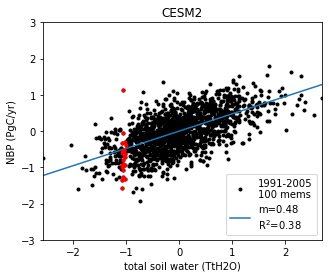

In [275]:
yy=slice('1991','2005')
exp='CESM2'
ds=dsets[exp]
nens=len(ds.ens)
x0=detrend_dim(ds.SW.sel(year=yy),'year')
x=x0.values.ravel()
y0=detrend_dim(ds.NBP.sel(year=yy),'year')
y=y0.values.ravel()

xv=np.array([x.min(),x.max()])
lm=sm.OLS(y,sm.add_constant(x)).fit()
m=str(np.round(lm.params[1],2))
r2=str(np.round(lm.rsquared,2))

plt.figure(figsize=[5,4])
plt.plot(x,y,'k.',label='1991-2005\n'+str(nens)+' mems');
plt.plot(xv,lm.params[0]+xv*lm.params[1],label='m='+m+'\n'+r'R$^2$='+r2)
plt.ylim([-3,3])
plt.title(exp)
plt.xlabel('total soil water (TtH2O)')
plt.legend(loc=4)
plt.xlim(xv);
plt.ylabel('NBP (PgC/yr)');

ix=((x0>-1.1)&(x0<-1)).values
plt.plot(x0.values[ix],y0.values[ix],'r.');

In [276]:
ees=np.tile(ds.ens,[15,1])[ix]
yys=np.tile(ds.year.sel(year=yy).values.reshape([-1,1]),[1,100])[ix]
nbps=y0.values[ix]
sws=x0.values[ix]

In [284]:
def nicemap(da,tstr,cbl,cmap=brown_green(),vmax=None,
            cticks=[],cticklabs=[],fsz=(8, 4)):
    fig = plt.figure(figsize=fsz)
    ax = fig.add_subplot(111,projection=ccrs.Robinson())
    ax.set_extent([-180, 180,-60,90], crs=ccrs.PlateCarree())
    

    mappable = da.plot(transform=ccrs.PlateCarree(),cmap=cmap,
                         add_colorbar=False,ax=ax,vmax=vmax,vmin=-vmax)

        
    ax.set_title(tstr)
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    ax.coastlines(color='grey')
    ax.add_feature(cfeature.BORDERS,edgecolor=[0.8,0.8,0.8])

    make_colorbar(ax,mappable,label=cbl,cticks=cticks,cticklabs=cticklabs)
    

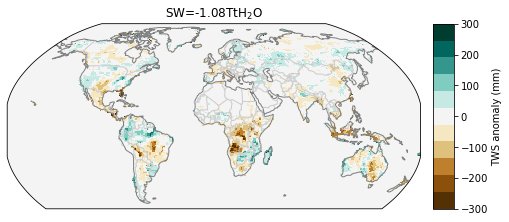

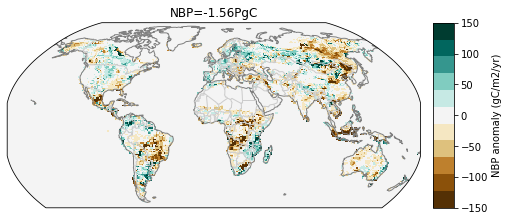

In [288]:
i=nbps.argsort()[0]
ee=ees[i]
yr=yys[i]
tws=get_one('TWS',ee,yr)
sw=str(np.round(sws[i],2))
nbp=str(np.round(nbps[i],2))
tstr=r'SW='+sw+'TtH$_2$O'
nicemap(tws,tstr,'TWS anomaly (mm)',vmax=300)
tstr='NBP='+nbp+'PgC'
y=get_one('NBP',ee,yr,24*60*60)
nicemap(y,tstr,'NBP anomaly (gC/m2/yr)',vmax=150)

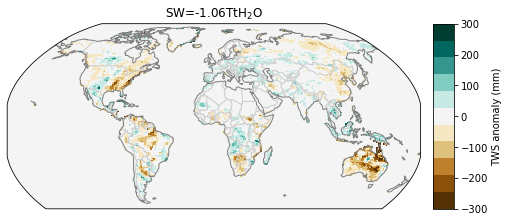

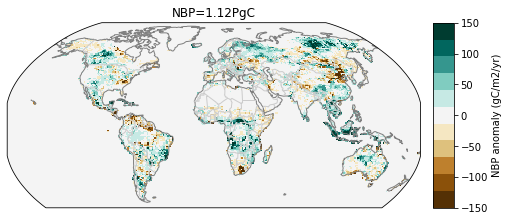

In [289]:
i=nbps.argsort()[-1]
ee=ees[i]
yr=yys[i]
tws=get_one('TWS',ee,yr)
sw=str(np.round(sws[i],2))
nbp=str(np.round(nbps[i],2))
tstr=r'SW='+sw+'TtH$_2$O'
nicemap(tws,tstr,'TWS anomaly (mm)',vmax=300)
tstr='NBP='+nbp+'PgC'
y=get_one('NBP',ee,yr,24*60*60)
nicemap(y,tstr,'NBP anomaly (gC/m2/yr)',vmax=150)

### PPE stuff

In [306]:
ds=xr.open_dataset('../data/PPE_glob_ann.nc')

In [307]:
x,y=ds['TWS'],ds['NBP']

In [308]:
x1=detrend_dim(x,'year')
y1=detrend_dim(y,'year')
ms=[]
for i in ds.ens:
    m, b, r, p, std_err = stats.linregress(x1.sel(ens=i),y1.sel(ens=i))
    ms.append(m)

In [309]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [310]:
def gp_plot(da):
    ix=range(1,501)
    p=np.concatenate([ds[p].sel(ens=ix).values.reshape([-1,1]) for p in ds.params.values],axis=1)
    x=da.sel(ens=ix)

    ## gaussian process regression
    # Instantiate a Gaussian Process model
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.1,normalize_y=True)
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(p, x);


    ypreds=[]
    for i in range(32):
        xpred = 0.5+np.zeros([20,32])
        xpred[:,i]=np.linspace(0,1,20)
        ypred, sigma = gp.predict(xpred, return_std=True)
        ypreds.append(ypred)

    da=xr.DataArray(ypreds,dims=['param','param_val'])
    da['param']=ds.params.values
    da['param_val']=np.linspace(0,1,20)
    dx=da.max(dim='param_val')-da.min(dim='param_val')

    plt.figure(figsize=[12,4])
    for i,p in enumerate(np.flip(dx.param[dx.argsort()[-10:].values])):
        plt.subplot(2,5,i+1)
        plt.plot(da.param_val,da.sel(param=p))
        plt.ylim([0.99*da.min(),1.01*da.max()])
        plt.xlim([0,1])
        plt.xticks([0,0.5,1],[])
        plt.title(p.values)

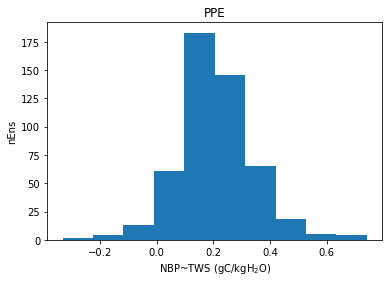

In [311]:
plt.hist(ms);
plt.title('PPE')
plt.xlabel('NBP~TWS (gC/kgH$_2$O)')
plt.ylabel('nEns');

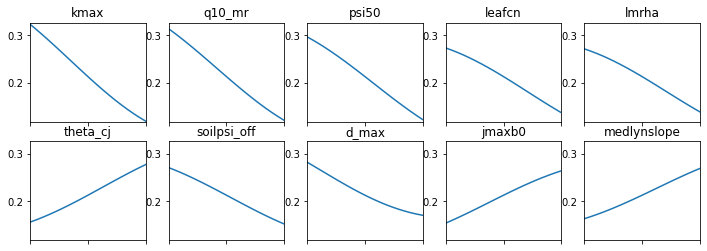

In [312]:
da=xr.DataArray(ms,dims='ens')
gp_plot(da)